# **Setup + Import Dataset:**

In [1]:
# Import libraries used:
import pandas as pd
import numpy as np

import re
import datetime as dt
from scipy.stats import randint as sp_randint, uniform as sp_uniform  # randint = uniform discrete random variable, uniform = uniform continuous random variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, log_loss, precision_score, balanced_accuracy_score

from sklearn.base import clone

In [4]:
# # Make working_data (training + val) and test dataframes:
# working_data = pd.read_csv('train.csv')
# test_all = pd.read_csv('train_v2.csv')

# # Make other dataframes (to merge with train and test):
# members_all = pd.read_csv('members_v3.csv')
# transactions_all = pd.read_csv('transactions.csv')
# transactions_all_test = pd.read_csv('transactions_v2.csv')

# # Combine all transactions into one dataframe (since we will need to filter by date later anyway to prevent leakage):
# transactions_all = pd.concat([transactions_all, transactions_all_test])

In [5]:
# # WARNING!:  These are 30.5 GB and 1.4 GB files -- run this cell only when 
# # necessary!
# %time user_logs_all = pd.read_csv('user_logs.csv')
# %time user_logs_all_test = pd.read_csv('user_logs_v2.csv')

# # Combine all user_logs into one dataframe (since we will need to filter by date later anyway to prevent leakage):
# %time user_logs_all = pd.concat([user_logs_all, user_logs_all_test])

CPU times: user 5min 17s, sys: 4min 37s, total: 9min 54s
Wall time: 12min 45s
CPU times: user 17.5 s, sys: 5.01 s, total: 22.5 s
Wall time: 26.8 s
CPU times: user 25.8 s, sys: 1min 56s, total: 2min 22s
Wall time: 3min 21s


In [6]:
# # Reset indices to remove duplicate numbers:
# transactions_all.reset_index(inplace=True, drop=True)
# user_logs_all.reset_index(inplace=True, drop=True)

In [7]:
# # Drop unused information from massive user_logs dataframe (410 mn observations!!):
# # We currently are not using any listening data from before July 2016, so we can remove all 
# # 2015/01-2016/06 observations for now:
# user_logs_all = user_logs_all[user_logs_all['date'] >= 20160701]

In [8]:
# # First-level data cleaning: Eliminate completely implausible values, etc.:

# # Data cleaning for members dataframe:
# members_all['bd'] = members_all['bd'].mask(members_all['bd'] < 10.0, np.NaN)
# members_all['bd'] = members_all['bd'].mask(members_all['bd'] > 100.0, np.NaN)
# members_all['registered_via'] = members_all['registered_via'].replace({-1: np.NaN})

# # Data cleaning for transactions df:
# transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] < transactions_all['membership_expire_date'].quantile(0.0001), np.NaN)
# transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] > transactions_all['membership_expire_date'].quantile(0.9999), np.NaN)

# # Data cleaning for user_logs df:
# user_logs_all = user_logs_all[(user_logs_all['total_secs'] < user_logs_all['total_secs'].quantile(0.9995))
#                              & (user_logs_all['num_25'] < user_logs_all['num_25'].quantile(0.9995))
#                              & (user_logs_all['num_50'] < user_logs_all['num_50'].quantile(0.9995))
#                              & (user_logs_all['num_75'] < user_logs_all['num_75'].quantile(0.9995))
#                              & (user_logs_all['num_985'] < user_logs_all['num_985'].quantile(0.9995))
#                              & (user_logs_all['num_100'] < user_logs_all['num_100'].quantile(0.9995))
#                              ]


In [9]:
# # Split working_data into train and val sets (necessary to split here in addition to CV below, because 
# # train has rebalanced classes, but we want to evaluate on val, test with original imbalanced classes):
# train_all, val_all = train_test_split(working_data, 
#                                       train_size=0.75, 
#                                       shuffle=True, 
#                                       stratify=working_data['is_churn'], 
#                                       random_state=42
#                                      )

In [10]:
# working_data.shape

(992931, 2)

In [11]:
# train_all.shape, val_all.shape, test_all.shape

((744698, 2), (248233, 2), (970960, 2))

In [12]:
# members_all.shape, transactions_all.shape, user_logs_all.shape

((6769473, 6), (22978755, 9), (155149646, 9))

## Subsets:  Take random samples to get subsets we can work with (otherwise too large a dataset to work with efficiently):

In [14]:
# # Subsets:  Take IID random subsamples of train, val, test that are small enough to work with.
# # train_all, val_all, test_all are all too big to work with.

# num_to_sample = 4000 # [?? To do: Change to 15-20k or so ??]

# # Straight samples mirroring original target variable distribution (keep class imbalance):
# train_imbalanced = train_all.sample(n=num_to_sample, replace=True, random_state=42)
# train_imbalanced.reset_index(inplace=True, drop=True)

# val = val_all.sample(n=num_to_sample, replace=True, random_state=42)
# val.reset_index(inplace=True, drop=True)

# test = test_all.sample(num_to_sample, replace=True, random_state=42)
# test.reset_index(inplace=True, drop=True)

In [15]:
# # Balanced classes samples from under-sampling the majority class (best approach given we 
# # have many more data points than we can use):

# from sklearn.utils import shuffle, resample

# target = 'is_churn'

# ratio = 1/2
# balanced_num = int(num_to_sample * ratio)

# # Train: train with balanced classes:

# not_churn_sample_train = train_all[train_all[target] == 0].sample(n=balanced_num, 
#                                                                   replace=True, 
#                                                                   random_state=42)
# yes_churn_sample_train = train_all[train_all[target] == 1].sample(n=balanced_num, 
#                                                                   replace=True, 
#                                                                   random_state=42)

# train = pd.concat([not_churn_sample_train, yes_churn_sample_train])
# train = shuffle(train, random_state=42)
# train.reset_index(inplace=True, drop=True)

# # Val: val_balanced version, just in case we want to use it later for cross-validation:

# not_churn_sample_val = val_all[val_all[target] == 0].sample(n=balanced_num, 
#                                                             replace=True, 
#                                                             random_state=42)
# yes_churn_sample_val = val_all[val_all[target] == 1].sample(n=balanced_num, 
#                                                             replace=True, 
#                                                             random_state=42)

# val_balanced = pd.concat([not_churn_sample_val, yes_churn_sample_val])
# val_balanced = shuffle(val_balanced, random_state=42)
# val_balanced.reset_index(inplace=True, drop=True)

In [17]:
# # Make a list of all msno IDs in the new subsets train, val and test, for our data_prep function:
# all_subsets_msnos = list(train['msno']) + list(val['msno']) + list(test['msno']) + list(train_imbalanced['msno']) # + list(val_balanced['msno'])

In [18]:
# # Take subsets of members, transactions, user_logs for only those users included in the above subsets 
# # (otherwise compute time is unfeasibly long, e.g., for all 24.6 mn rows in user_logs):
# members = members_all[members_all['msno'].isin(all_subsets_msnos)]
# transactions = transactions_all[transactions_all['msno'].isin(all_subsets_msnos)]
# user_logs = user_logs_all[user_logs_all['msno'].isin(all_subsets_msnos)]

# **Data Inspection: What Info Do We Have?**

In [19]:
# train.shape, val.shape, test.shape

((4000, 2), (4000, 2), (4000, 2))

In [20]:
# members.shape, transactions.shape, user_logs.shape

((14059, 6), (260341, 9), (1725697, 9))

In [21]:
# train.head()

msno  is_churn
0  7XzKdS9Twy5iCOBbJJOCWSDO3yQZe6N9X406X/RNUmE=         0
1  1fGqmenGWbtZjovaEVGoJnQUxkr75kBSTSRR2PKSbqc=         1
2  gwZyVGRXGMbZpUZVRgyfuB8WRoFEuu+nIARamrw45UI=         0
3  /NcOI9aXZryS41szLZHqxO/aKqgUE/6sValyWPjAYYM=         1
4  Y3F1e044Yo4IjWOGQiYgIgYb5OrvG33J4kKlctqLIRc=         1

In [22]:
# val.head()

msno  is_churn
0  Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0
1  Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0
2  j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0
3  KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1
4  gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0

In [23]:
# test.head()

msno  is_churn
0  EbMqBply0dkY1HpfE7EaZSkjP+k4zb2OTnX1jp57WC0=         0
1  LEUnZ/CSq5XOQTRAy0gpdtSeJIpDHsLdWzgbZ4ZbxUM=         0
2  arrNOS52gp074Cvge+dEOBNF1md0JJ/iweM6brfZ+0c=         0
3  VektVJLpDqBZWwHIEV1ZVnq5OFFdyWrkQiyeFwGeAEk=         0
4  Q8eDeUpFEpQhTrsEWkGA+0IUxwru76i4cBsruzPTJeo=         0

In [24]:
# members.head()

msno  city    bd  gender  \
94    bPHi7VPQkMtdeIqJAktzYSITpRSt9F9mCdhddPTSlOY=    15  17.0  female   
309   0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=    15  23.0  female   
645   UXmaug3gaadL7IPD+liAWEObCyiwGERi1cU/I0TN3Ik=     1   NaN     NaN   
755   oPAvKbLLEAxCbKmSQTogQRkaHs+zP4lQa1CwFZSNi2o=     1   NaN     NaN   
1068  oXrWnFQd/ZhkZ/8s3j8bRHH7ucPGlFJYWTh34RCf9uM=     1   NaN     NaN   

      registered_via  registration_init_time  
94               3.0                20141021  
309              7.0                20141103  
645              9.0                20161231  
755              4.0                20170105  
1068             7.0                20170121

In [25]:
# transactions.head()

msno  payment_method_id  \
19   Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=                 39   
114  jyA9StM/2EHPefRmJxHn5ryWxCQiP+PS2/FYNG5K3KI=                 37   
275  F0hEmfLOtr6rmWfYEzx2dBHS6niQ85CWwkp6L7YBreA=                 34   
568  FVwf2pTZlDKiF7qYRt79o5aNSYhpq8gGIla9Kduouj0=                 41   
591  HtH2C8O0mU3lNzvdHwNSHjcJrgZF+DvisqDTXO/roiw=                 40   

     payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
19                  30              149                 149              1   
114                 31              149                 149              1   
275                 30              149                 149              1   
568                 30               99                  99              1   
591                 30              149                 149              1   

     transaction_date  membership_expire_date  is_cancel  
19           20150930              20151108.0          0  
114          20150131              20150301.0          0  
275          20160331              20160430.0          0  
568          20161202              20170102.0          0  
591          20160916              20161015.0          0

In [26]:
# user_logs.head()

msno      date  num_25  num_50  \
1497  KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=  20160713      26       3   
1498  KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=  20160903      13       2   
1499  KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=  20161104       1       0   
1500  KAtqQnhOokDvGkV866gfxl0LhH7XLVgZgCYIzDurfUA=  20170216      11       3   
3295  BUvho2+grkZGPSX0jNnsWO2zcAPGZ6BisTaPFi+pKS0=  20170126       1       0   

      num_75  num_985  num_100  num_unq  total_secs  
1497       2        2       28       57    8308.725  
1498       0        1        9       25    2719.579  
1499       1        0        1        3     278.647  
1500       0        2       27       40    7174.197  
3295       0        0       21       21    4687.039

### Data for 1 Individual User: Lookup 1 Individual User's Info Across All Datasets:

In [466]:
# # Get the msno id for a random user in the train_all dataset:
# single_user_msno = train_all.sample(n=1, replace=False, random_state=42)
# single_user_msno = list(single_user_msno['msno'])
# print(f"Randomly selected user ID (msno): \n{single_user_msno}")

Randomly selected user ID (msno): 
['PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=']


In [467]:
# train_all[train_all['msno'].isin(single_user_msno)]

msno  is_churn
279579  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=         0

In [468]:
# members_all[members_all['msno'].isin(single_user_msno)]

msno  city  bd gender  \
6506958  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=     1 NaN    NaN   

         registered_via  registration_init_time  
6506958             7.0                20150711

In [469]:
# transactions_all[transactions_all['msno'].isin(single_user_msno)].sort_values(by='transaction_date', ascending=True)

msno  payment_method_id  \
17256051  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
11989566  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
9658842   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
2057491   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
5277238   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
6394025   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
2129536   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
5532960   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
17654922  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
9165470   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
14268554  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
19886021  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
18963670  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
3834320   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
3058938   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
14762864  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
2581696   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
1466921   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
1229964   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
3837165   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   
22846162  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=                 41   

          payment_plan_days  plan_list_price  actual_amount_paid  \
17256051                 30               99                  99   
11989566                 30               99                  99   
9658842                  30               99                  99   
2057491                  30               99                  99   
5277238                  30               99                  99   
6394025                  30               99                  99   
2129536                  30               99                  99   
5532960                  30               99                  99   
17654922                 30               99                  99   
9165470                  30               99                  99   
14268554                 30               99                  99   
19886021                 30               99                  99   
18963670                 30               99                  99   
3834320                  30               99                  99   
3058938                  30               99                  99   
14762864                 30               99                  99   
2581696                  30               99                  99   
1466921                  30               99                  99   
1229964                  30               99                  99   
3837165                  30               99                  99   
22846162                 30               99                  99   

          is_auto_renew  transaction_date  membership_expire_date  is_cancel  
17256051              1          20150711              20150811.0          0  
11989566              1          20150811              20150911.0          0  
9658842               1          20150911              20151011.0          0  
2057491               1          20151011              20151111.0          0  
5277238               1          20151111              20151211.0          0  
6394025               1          20151211              20160111.0          0  
2129536               1          20160111              20160211.0          0  
5532960               1          20160211              20160311.0          0  
17654922              1          20160311              20160411.0          0  
9165470               1          20160411              20160511.0   

In [470]:
# user_logs_all[user_logs_all['msno'].isin(single_user_msno)].sort_values(by='date', ascending=True)

msno      date  num_25  \
267922782  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20160701       1   
277886440  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20160703       1   
282544382  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20160704       0   
297716200  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20160705       2   
302068943  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20160706       1   
...                                                 ...       ...     ...   
46535835   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20170131       2   
47281672   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20170211       3   
60100808   PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20170228       4   
402007092  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20170307       0   
405806782  PhjrA8nGMJvsdZYSlllGhctpDypdIgrJeIo6flAd7Y0=  20170330       4   

           num_50  num_75  num_985  num_100  num_unq  total_secs  
267922782       2       0        0       45       46   11306.486  
277886440       0       0        0        2        3     476.935  
282544382       0       0        3       68       71   18364.525  
297716200       1       2        0      108      113   28650.495  
302068943       0       1        2      109      112   28653.652  
...           ...     ...      ...      ...      ...         ...  
46535835        2       0        1        0        4     493.613  
47281672        5       2        3        7       18    3483.904  
60100808        6       2        3        0       14    1663.688  
402007092       0       0        1        4        4    1056.787  
405806782       3       2        0        1        9     773.111  

[76 rows x 9 columns]

# **Data Prep. & Feature Engineering:**

In [27]:
# # Set the correct cutoff date for the dataset = first day of the renewal period (to prevent data leakage):
# cutoff_train = dt.datetime(2017, 2, 1)
# cutoff_test = dt.datetime(2017, 3, 1)

In [29]:
# # Data prep. for members, transactions, user_logs:

# # Members:
# members.loc[:, 'registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
# members.rename(columns={'bd': 'age'}, inplace=True)

# # Transactions:
# # [?? To do... ??]
# transactions.loc[:, 'transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
# transactions.loc[:, 'membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
# transactions.loc[:, 'actual_amount_paid_per_30_days'] = transactions['actual_amount_paid'] / (transactions['payment_plan_days'] / 30)
# transactions['actual_amount_paid_per_30_days'].replace({np.inf: np.NaN}, inplace=True)

# # User Logs (listening data):
# user_logs.loc[:, 'date'] = pd.to_datetime(user_logs['date'], format='%Y%m%d')

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [30]:
# # Function that does all data prep on train, val, test:

# def data_prep(dataframe, members, transactions, user_logs, cutoff_date):
#     # [?? To do: Best to make copies or no ??]
#     df = dataframe.copy()
#     members = members.copy()
#     transactions = transactions[transactions['transaction_date'] < cutoff_date].copy()
#     user_logs = user_logs[user_logs['date'] < cutoff_date].copy()
    
# #     cutoff_date = cutoff_date
#     date_1_month_ago = cutoff_date + pd.DateOffset(months=-1)
#     date_6_months_ago = cutoff_date + pd.DateOffset(months=-6)
    
#     # Merge key features into main dataframe:
#     df = pd.merge(df, members, how='left', on='msno')
    
#     # Main dataframe:  OneHot encoding for 0/1 binary features with NaNs:
#     columns_for_onehot = ['gender']
#     encoder_onehot = ce.OneHotEncoder(use_cat_names=True)
#     encoded_columns_onehot = encoder_onehot.fit_transform(df[columns_for_onehot])
    
# #     encoded_columns_onehot['msno'] = df['msno']                       # Add back msno numbers to merge
#     df = pd.merge(df, encoded_columns_onehot, how='left', left_index=True, right_index=True)
    
#     # NEW FEATURES:
    
#     df.loc[:, 'total_days_since_joined'] = (cutoff_date - df['registration_init_time']).dt.days
    
#     # More computationally efficient to set these columns as default=NaN, rather than one-by-one as the 
#     # elif... part of the below for loop:
#     df.loc[:, 'cost_per_month'] = np.NaN
#     df.loc[:, 'on_auto_renew'] = np.NaN
#     df.loc[:, 'payment_method_latest'] = np.NaN
#     df.loc[:, 'churn_returned_in_past'] = np.NaN
#     df.loc[:, 'churn_returned_num_times'] = np.NaN
#     df.loc[:, 'churned_full_in_past'] = np.NaN
#     df.loc[:, 'churned_full_num_times'] = np.NaN
#     df.loc[:, 'churned_any_in_past'] = np.NaN
#     df.loc[:, 'churned_any_num_times'] = np.NaN

#     df.loc[:, 'total_mins_last_month'] = np.NaN
#     df.loc[:, 'total_mins_last_6_months'] = np.NaN
#     df.loc[:, 'total_mins_last_month'] = np.NaN
#     df.loc[:, 'total_mins_last_6_months'] = np.NaN

#     df.loc[:, 'num_unique_last_month'] = np.NaN
#     df.loc[:, 'num_unique_last_6_months'] = np.NaN
#     df.loc[:, 'num_songs_started_last_month'] = np.NaN
#     df.loc[:, 'num_songs_started_last_6_months'] = np.NaN
#     df.loc[:, 'num_songs_listened_last_month'] = np.NaN
#     df.loc[:, 'num_songs_listened_last_6_months'] = np.NaN
#     df.loc[:, 'num_songs_finished_last_month'] = np.NaN
#     df.loc[:, 'num_songs_finished_last_6_months'] = np.NaN

#     df.loc[:, 'songs_affinity_nps_last_month'] = np.NaN
#     df.loc[:, 'songs_affinity_nps_last_6_months'] = np.NaN
#     df.loc[:, 'songs_percent_loved_last_month'] = np.NaN
#     df.loc[:, 'songs_percent_loved_last_6_months'] = np.NaN
#     df.loc[:, 'songs_percent_disliked_last_month'] = np.NaN
#     df.loc[:, 'songs_percent_disliked_last_6_months'] = np.NaN
    
#     df.loc[:, 'active_days_L30_last_month'] = np.NaN
#     df.loc[:, 'active_days_L30_last_6_months_avg'] = np.NaN
#     df.loc[:, 'is_MAU_last_month'] = np.NaN
#     df.loc[:, 'is_WAU_last_month'] = np.NaN
#     df.loc[:, 'is_WAU_last_6_months'] = np.NaN
#     df.loc[:, 'is_DAU_last_month'] = np.NaN
#     df.loc[:, 'is_DAU_last_6_months'] = np.NaN
    
#     for row_num in df.index:
#         msno = df.loc[row_num, 'msno']

#         # ------------------------ TRANSACTIONS/SUBSCRIPTION FEATURES -------------------------------------------
        
#         # User's transactions history: pull in useful data from transactions logs:
#         transactions_this_user = transactions[transactions['msno'] == msno].sort_values(by='transaction_date', ascending=True)
# #         txns_last_month = transactions_this_user[transactions_this_user['transaction_date'] > date_1_month_ago]
# #         txns_last_6_months = transactions_this_user[transactions_this_user['transaction_date'] > date_6_months_ago]

#         # New features for transactions/subscription history:
#         if msno in set(transactions['msno']):
#             df.loc[row_num, 'cost_per_month'] = transactions_this_user.iloc[-1]['actual_amount_paid_per_30_days']
#             df.loc[row_num, 'on_auto_renew'] = transactions_this_user.iloc[-1]['is_auto_renew']
#             df.loc[row_num, 'payment_method_latest'] = transactions_this_user.iloc[-1]['payment_method_id']

#             # Make features for 'has churned before' and 'churned before # times':
#             cancellations = transactions_this_user[transactions_this_user['is_cancel'] == 1]['transaction_date']
#             churn_returned_num_times = 0
#             churned_full_num_times = 0
#             for cancel_event in cancellations:
#                 # Check whether: 
#                 # (a) simply upgraded subscription type (didn't churn); 
#                 # (b) half-churned or "churn-returned": ended subscription, but reactivated within 30 days; or 
#                 # (c) full-churned: ended subscription and did not reactivate within 30 days):
#                 plan_change_range = [cancel_event + pd.DateOffset(days=-1), cancel_event + pd.DateOffset(days=1)]
#                 plan_change_conditions = (transactions_this_user['transaction_date'] >= plan_change_range[0]) & (transactions_this_user['transaction_date'] <= plan_change_range[1])
#                 plan_change = (transactions_this_user[plan_change_conditions]['is_cancel'] == 0).sum() >= 1

#                 renewed_range = [cancel_event + pd.DateOffset(days=-14), cancel_event + pd.DateOffset(days=30)]
#                 renewed_conditions = (transactions_this_user['transaction_date'] >= renewed_range[0]) & (transactions_this_user['transaction_date'] <= renewed_range[1])
#                 renewed = (transactions_this_user[renewed_conditions]['is_cancel'] == 0).sum() >= 1

#                 if renewed == True & plan_change == False:
#                     churn_returned_num_times += 1
#                 elif renewed == False:
#                     churned_full_num_times += 1
#                 # elif renewed == True & plan_change == True:
#                     # User simply changed plans (upgraded/downgraded) --> no churn event at all.

#             df.loc[row_num, 'churn_returned_in_past'] = churn_returned_num_times >= 1
#             df.loc[row_num, 'churn_returned_num_times'] = churn_returned_num_times
#             df.loc[row_num, 'churned_full_in_past'] = churned_full_num_times >= 1
#             df.loc[row_num, 'churned_full_num_times'] = churned_full_num_times
#             df.loc[row_num, 'churned_any_in_past'] = (churn_returned_num_times + churned_full_num_times) >= 1
#             df.loc[row_num, 'churned_any_num_times'] = churn_returned_num_times + churned_full_num_times
        
#         # ------------------------ LISTENING/USAGE FEATURES -----------------------------------------------------
        
#         # User's listening history: pull in useful data for that user from user_logs (listening data):
#         listening_logs_this_user = user_logs[user_logs['msno'] == msno].sort_values(by='date', ascending=True)
#         logs_last_month = listening_logs_this_user[listening_logs_this_user['date'] > date_1_month_ago]
#         logs_last_6_months = listening_logs_this_user[listening_logs_this_user['date'] > date_6_months_ago]

#         # New features re the user's listening behavior/history:
        
#         # Make INTs for these values --> saves compute time below (vs. df lookup in train, val, test 50+ times for every row):
#         num_25_last_month = logs_last_month['num_25'].sum()
#         num_50_last_month = logs_last_month['num_50'].sum()
#         num_75_last_month = logs_last_month['num_75'].sum()
#         num_985_last_month = logs_last_month['num_985'].sum()
#         num_100_last_month = logs_last_month['num_100'].sum()

#         num_25_last_6_months = logs_last_6_months['num_25'].sum()
#         num_50_last_6_months = logs_last_6_months['num_50'].sum()
#         num_75_last_6_months = logs_last_6_months['num_75'].sum()
#         num_985_last_6_months = logs_last_6_months['num_985'].sum()
#         num_100_last_6_months = logs_last_6_months['num_100'].sum()

#         num_songs_started_last_month = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
#         num_songs_started_last_6_months = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months

#         if df.loc[row_num, 'msno'] in set(user_logs['msno']):
#             df.loc[row_num, 'total_mins_last_month'] = logs_last_month['total_secs'].sum() / 60
#             df.loc[row_num, 'total_mins_last_6_months'] = logs_last_6_months['total_secs'].sum() / 60
#             df.loc[row_num, 'num_unique_last_month'] = logs_last_month['num_unq'].sum()
#             df.loc[row_num, 'num_unique_last_6_months'] = logs_last_6_months['num_unq'].sum()
#             df.loc[row_num, 'num_songs_started_last_month'] = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
#             df.loc[row_num, 'num_songs_started_last_6_months'] = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
#             df.loc[row_num, 'num_songs_listened_last_month'] = num_75_last_month + num_985_last_month + num_100_last_month
#             df.loc[row_num, 'num_songs_listened_last_6_months'] = num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
#             df.loc[row_num, 'num_songs_finished_last_month'] = num_100_last_month
#             df.loc[row_num, 'num_songs_finished_last_6_months'] = num_100_last_6_months

#             df.loc[row_num, 'songs_affinity_nps_last_month'] = (num_985_last_month + num_100_last_month - num_25_last_month - num_50_last_month) / num_songs_started_last_month
#             df.loc[row_num, 'songs_affinity_nps_last_6_months'] = (num_985_last_6_months + num_100_last_6_months - num_25_last_6_months - num_50_last_6_months) / num_songs_started_last_6_months
#             df.loc[row_num, 'songs_percent_loved_last_month'] = (num_985_last_month + num_100_last_month) / num_songs_started_last_month
#             df.loc[row_num, 'songs_percent_loved_last_6_months'] = (num_985_last_6_months + num_100_last_6_months) / num_songs_started_last_6_months
#             df.loc[row_num, 'songs_percent_disliked_last_month'] = num_25_last_month / num_songs_started_last_month
#             df.loc[row_num, 'songs_percent_disliked_last_6_months'] = num_25_last_6_months / num_songs_started_last_6_months
            
#             # Active usage metrics (D/W/MAU is daily/weekly/monthly active user):
#             df.loc[row_num, 'active_days_L30_last_month'] = logs_last_month.shape[0]
#             df.loc[row_num, 'active_days_L30_last_6_months_avg'] = logs_last_6_months.shape[0] / 6
#             if df.loc[row_num, 'registration_init_time'] < date_6_months_ago:
#                 df.loc[row_num, 'is_WAU_last_6_months'] = df.loc[row_num, 'active_days_L30_last_6_months_avg'] >= (6/12*52)
#                 df.loc[row_num, 'is_DAU_last_6_months'] = df.loc[row_num, 'active_days_L30_last_6_months_avg'] >= (6*30*5/7)
    
#     # Also user listening data like above, but just more computationally efficient outside of the above for loop:
#     df.loc[:, 'is_MAU_last_month'] = df['active_days_L30_last_month'] >= 1
#     df.loc[:, 'is_WAU_last_month'] = df['active_days_L30_last_month'] >= 5
#     df.loc[:, 'is_DAU_last_month'] = df['active_days_L30_last_month'] >= (30*5/7)
#     df.loc[:, 'avg_min_per_song'] = df['total_mins_last_month'] / df['num_songs_started_last_month']
#     df.loc[:, 'last_6_months_avg_monthly_mins'] = df['total_mins_last_6_months'] / 6
#     df.loc[:, 'last_month_vs_6_month_avg'] = df['total_mins_last_month'] / df['last_6_months_avg_monthly_mins']
    
#     return df

In [31]:
# # Do data prep on train (balanced sample), val, test:
# %time train = data_prep(train, members, transactions, user_logs, cutoff_train)
# %time val = data_prep(val, members, transactions, user_logs, cutoff_train)
# %time test = data_prep(test, members, transactions, user_logs, cutoff_test)

# # Do data prep on train_imbalanced (keeps original imbalanced class distribution):
# %time train_imbalanced = data_prep(train_imbalanced, members, transactions, user_logs, cutoff_train)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 36min 19s, sys: 13.1 s, total: 36min 32s
Wall time: 36min 41s
CPU times: user 36min 18s, sys: 7.59 s, total: 36min 25s
Wall time: 36min 30s


In [35]:
# train

msno  is_churn  city   age  \
0     7XzKdS9Twy5iCOBbJJOCWSDO3yQZe6N9X406X/RNUmE=         0   6.0  23.0   
1     1fGqmenGWbtZjovaEVGoJnQUxkr75kBSTSRR2PKSbqc=         1   1.0   NaN   
2     gwZyVGRXGMbZpUZVRgyfuB8WRoFEuu+nIARamrw45UI=         0  13.0  34.0   
3     /NcOI9aXZryS41szLZHqxO/aKqgUE/6sValyWPjAYYM=         1  22.0  26.0   
4     Y3F1e044Yo4IjWOGQiYgIgYb5OrvG33J4kKlctqLIRc=         1  13.0  18.0   
...                                            ...       ...   ...   ...   
3995  /ZQU4o7o8x9WlyPmvtwgSaFsdkcrk8ZAsolRXIzcv00=         0   1.0   NaN   
3996  JdgUljwnvPTXQdtUj6ViBF4hIr1xT9X4sa2OJ1we0Mo=         0   5.0   NaN   
3997  IEuNtYtW/Fix6BBBMWKxPsK+dkEvYmejtXRNSXOATF8=         0   1.0   NaN   
3998  X78V9mHZiW1/UI9+obDtyB9OtMXpVarUbOg4DQLZiE0=         1   1.0   NaN   
3999  auV+SOftKYDFjzWobYQ6bXDp7yaEX9I1XeTgoQ3pX5c=         1   5.0  24.0   

      gender  registered_via registration_init_time  gender_male  gender_nan  \
0       male             9.0             2014-05-05            1           0   
1        NaN             7.0             2010-12-09            0           1   
2     female             7.0             2011-03-19            0           0   
3       male             4.0             2015-10-20            1           0   
4       male             9.0             2012-04-01            1           0   
...      ...             ...                    ...          ...         ...   
3995     NaN             7.0             2015-09-05            0           1   
3996     NaN             9.0             2014-11-02            0           1   
3997     NaN             7.0             2013-10-09            0           1   
3998     NaN             7.0             2013-10-28            0           1   
3999  female             9.0             2007-11-30            0           0   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                        14.0   
1                 0  ...                         3.0   
2                 1  ...                        16.0   
3                 0  ...                        26.0   
4                 0  ...                         6.0   
...             ...  ...                         ...   
3995              0  ...                         NaN   
3996              0  ...                        28.0   
3997              0  ...                        22.0   
3998              0  ...                         NaN   
3999              1  ...                        18.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                             12.333333               True               True   
1                              2.000000               True              False   
2                              9.000000               True               True   
3                             25.500000               True               True   
4                              8.833333               True               True   
...                                 ...                ...                ...   
3995                                NaN              False              False   
3996                          26.833333               True               True   
3997                          23.000000               True               True   
3998                                NaN              False              False   
3999                          16.166667               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False              False                False   
1                   False              False                False   
2                   False              False                False   
3                   False               True                False   
4                   False              False                False   
...                   ...                ...                  ...   
3995                  NaN              Fals

In [428]:
# train_imbalanced

msno  is_churn  city   age  \
0     GjdWJ5iCawbLfsPpRI5xkIwwpd8oCAGiB5dLCBFIEog=         0   1.0   NaN   
1     7/7ebApkG0bEw7h1G2tL8ETyhAbqqTRN/7ZXHliRY90=         0  22.0  25.0   
2     gQTPK2W2+Fbwhx7l04kg/yMyOL68zbXibrqt/SMtjc8=         0  22.0  31.0   
3     o+ocfyzqpxd79+Lt1W305vQ90gnqOpToLRQdxnLeUDE=         0  22.0  25.0   
4     Uxut7Crxl0njiRxUo9EVcM5+wp9nLlVMMROQakXjmVI=         0   1.0   NaN   
...                                            ...       ...   ...   ...   
3995  y9L8pvv8e/fmN2veu/PXT1ISKSey/KoOyOgaOgbvEEc=         0   1.0  21.0   
3996  diAE1/yaFrRswjrfL3SeLEX2eQFc3QR2uj0qMSVaWtA=         0   1.0   NaN   
3997  CzUCPtR0ujVwloALeDA1mIvWpAEvm49DVeLwKZN5O5c=         0   4.0   NaN   
3998  fDjLB1GMfs6VBESCR0RImglE9N8Scyhcw5jWoV3mGv8=         0   1.0   NaN   
3999  e+1VuhtJLpgyRiLWBZfdSZaYxEq6ygJIBtLA0h2dUCo=         0   NaN   NaN   

      gender  registered_via registration_init_time  gender_nan  \
0        NaN             7.0             2016-06-04           1   
1     female             3.0             2013-02-27           0   
2       male             9.0             2006-10-22           0   
3     female             9.0             2015-03-27           0   
4        NaN             7.0             2014-08-15           1   
...      ...             ...                    ...         ...   
3995  female             3.0             2014-12-28           0   
3996     NaN             7.0             2011-08-08           1   
3997    male             9.0             2005-03-04           0   
3998     NaN             7.0             2012-02-18           1   
3999     NaN             NaN                    NaT           1   

      gender_female  gender_male  ...  active_days_L30_last_month  \
0                 0            0  ...                         0.0   
1                 1            0  ...                        25.0   
2                 0            1  ...                        18.0   
3                 1            0  ...                        12.0   
4                 0            0  ...                        23.0   
...             ...          ...  ...                         ...   
3995              1            0  ...                        26.0   
3996              0            0  ...                        27.0   
3997              0            1  ...                        29.0   
3998              0            0  ...                        27.0   
3999              0            0  ...                         NaN   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                             10.000000              False              False   
1                             20.666667               True               True   
2                             20.666667               True               True   
3                             14.500000               True               True   
4                             13.666667               True               True   
...                                 ...                ...                ...   
3995                          28.166667               True               True   
3996                          23.333333               True               True   
3997                          15.500000               True               True   
3998                          29.833333               True               True   
3999                                NaN              False              False   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False              False                False   
1                   False               True                False   
2                   False              False                False   
3                   False              False                False   
4                   False               True                False   
...                   ...                ...                  ...   
3995                 True               Tru

In [36]:
# val

msno  is_churn  city   age  \
0     Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0   1.0   NaN   
1     Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0   NaN   NaN   
2     j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0   4.0  30.0   
3     KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1   1.0   NaN   
4     gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0   1.0   NaN   
...                                            ...       ...   ...   ...   
3995  UHr6lPaCRvduKUWz8liocYz3a5lWUXTAD3NI75OtG+o=         0   1.0   NaN   
3996  1xK5dRG0b54thjjrwIaO4aTI04YJ+wUvt+NoEFKAdW8=         0  13.0  44.0   
3997  5KabhyfWnb5fpoKTNQ3I7a2pcFuIuV9vx0wtNNkdUbE=         0  14.0  24.0   
3998  IKxsqk5JWbzBmC/x+Fea6ftOozb1/4pNt/9WgjQPSn8=         0   1.0   NaN   
3999  jeQLof6KRAT+U/wWLtXSrT+T5+keOvqHEMa/tRrMSf4=         0   1.0   NaN   

      gender  registered_via registration_init_time  gender_nan  gender_male  \
0        NaN             4.0             2016-04-29           1            0   
1        NaN             NaN                    NaT           1            0   
2       male             9.0             2011-03-07           0            1   
3        NaN             4.0             2016-04-30           1            0   
4        NaN             7.0             2013-02-03           1            0   
...      ...             ...                    ...         ...          ...   
3995     NaN             7.0             2010-04-30           1            0   
3996  female             9.0             2008-10-05           0            0   
3997    male             3.0             2012-11-11           0            1   
3998     NaN             7.0             2012-12-23           1            0   
3999     NaN             7.0             2016-02-03           1            0   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                        29.0   
1                 0  ...                         NaN   
2                 0  ...                        23.0   
3                 0  ...                        15.0   
4                 0  ...                         0.0   
...             ...  ...                         ...   
3995              0  ...                        12.0   
3996              1  ...                         6.0   
3997              0  ...                        22.0   
3998              0  ...                        21.0   
3999              0  ...                         3.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                             21.166667               True               True   
1                                   NaN              False              False   
2                             26.333333               True               True   
3                              6.666667               True               True   
4                              3.166667              False              False   
...                                 ...                ...                ...   
3995                          11.833333               True               True   
3996                           1.000000               True               True   
3997                          27.333333               True               True   
3998                          12.166667               True               True   
3999                           3.500000               True              False   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False               True                False   
1                     NaN              False                  NaN   
2                    True               True                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
3995                False              Fals

In [698]:
# test

msno  is_churn  city   age  \
0     EbMqBply0dkY1HpfE7EaZSkjP+k4zb2OTnX1jp57WC0=         0   NaN   NaN   
1     LEUnZ/CSq5XOQTRAy0gpdtSeJIpDHsLdWzgbZ4ZbxUM=         0   1.0   NaN   
2     arrNOS52gp074Cvge+dEOBNF1md0JJ/iweM6brfZ+0c=         0  13.0  23.0   
3     VektVJLpDqBZWwHIEV1ZVnq5OFFdyWrkQiyeFwGeAEk=         0   5.0  30.0   
4     Q8eDeUpFEpQhTrsEWkGA+0IUxwru76i4cBsruzPTJeo=         0   6.0  53.0   
...                                            ...       ...   ...   ...   
3995  uPHb9mZxnuwWUpi3jJvBaTrrV0Ik8IzAKi6fkSJiopI=         0   4.0  27.0   
3996  Svwp+DONcTalpdI9NA2Jpob+L4kj/tFh5+HquXn/AGM=         0   1.0   NaN   
3997  cWVRI5YmW5X5p6hbaCHEvZmQpYHiQDkTMl73JTuSCzE=         0   NaN   NaN   
3998  ZlyFE6P4pwzxwjiW6PN54NcOjUcQGAY+3Cl+QO5/+T0=         0   NaN   NaN   
3999  u2Mr3ExsyKT28fcmFMdqUhoJNE29vn5Gil1P0QPpapA=         0  11.0  35.0   

      gender  registered_via registration_init_time  gender_nan  \
0        NaN             NaN                    NaT           1   
1        NaN             7.0             2011-07-23           1   
2     female             9.0             2011-05-10           0   
3       male             7.0             2009-12-11           0   
4       male             9.0             2005-02-15           0   
...      ...             ...                    ...         ...   
3995  female             3.0             2012-06-20           0   
3996     NaN             7.0             2016-08-09           1   
3997     NaN             NaN                    NaT           1   
3998     NaN             NaN                    NaT           1   
3999     NaN             7.0             2010-05-28           1   

      gender_female  gender_male  ...  active_days_L30_last_month  \
0                 0            0  ...                         NaN   
1                 0            0  ...                         3.0   
2                 1            0  ...                        20.0   
3                 0            1  ...                        10.0   
4                 0            1  ...                         5.0   
...             ...          ...  ...                         ...   
3995              1            0  ...                        27.0   
3996              0            0  ...                         9.0   
3997              0            0  ...                         NaN   
3998              0            0  ...                         NaN   
3999              0            0  ...                         8.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                                   NaN              False              False   
1                             11.500000               True              False   
2                              9.833333               True               True   
3                              9.833333               True               True   
4                             15.000000               True               True   
...                                 ...                ...                ...   
3995                          29.166667               True               True   
3996                          10.500000               True               True   
3997                                NaN              False              False   
3998                                NaN              False              False   
3999                           8.833333               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                     NaN              False                  NaN   
1                   False              False                False   
2                   False              False                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
3995                 True               Tru

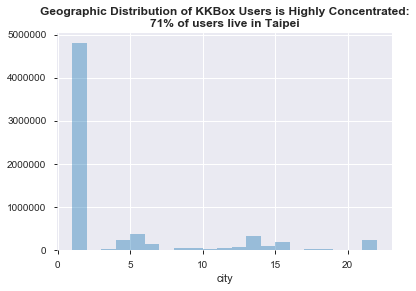

In [424]:
# # Members by city: Almost all (70%) live in Taipei:
# cities_all = pd.DataFrame(members_all['city'].value_counts(dropna=False))
# cities_all['%'] = members_all['city'].value_counts(normalize=True, dropna=False)
# cities_all.reset_index(inplace=True)
# cities_all.rename(columns={'index': 'city', 'city': 'customers'}, inplace=True)

# sns.distplot(members_all['city'], bins=members_all['city'].nunique(), kde=False)
# plt.title(f"Geographic Distribution of KKBox Users is Highly Concentrated:\n{cities_all[cities_all['city'] == 1]['%'][0] * 100:.0f}% of users live in Taipei", fontweight="bold")
# plt.show()

**External review only: Export key dataframes as CSVs --> cell that imports/makes new dfs from those CSVs:**

*(i.e., save a ton of time by letting reviewers run a quick test of everything below, without needing to wait 2+ hours for the above data prep. code cells to run):*

In [681]:
# # Save files needed below as CSVs:
# train.to_csv('pre_prepped_data_for_code_reviewers/train_sample.csv')
# train_imbalanced.to_csv('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
# val.to_csv('pre_prepped_data_for_code_reviewers/val_sample.csv')
# test.to_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')

# External Reviewers Start Here (to skip above data prep., takes a long time):

In [39]:
# For external reviewers only:

# Make quick dataframes from pre-prepped CSV files above:
train = pd.read_csv('https://raw.githubusercontent.com/chrishuskey/DS-Unit-2-Build-Week-Project/master/pre_prepped_data_for_code_reviewers/train_sample.csv')
train_imbalanced = pd.read_csv('https://raw.githubusercontent.com/chrishuskey/DS-Unit-2-Build-Week-Project/master/pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
val = pd.read_csv('https://raw.githubusercontent.com/chrishuskey/DS-Unit-2-Build-Week-Project/master/pre_prepped_data_for_code_reviewers/val_sample.csv')
test = pd.read_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')

# **Data Exploration:**

In [422]:
# Take a look at our training data with Pandas profiling:
import pandas_profiling

train_imbalanced_profile_report = train_imbalanced.profile_report(
    check_correlation_pearson=False, 
    correlations={
        'pearson': False, 
        'spearman': False, 
        'kendall': False, 
        'phi_k': False, 
        'cramers': False, 
        'recoded':False
    }, 
    plot={'histogram': {'bayesian_blocks_bins': False}}
)
train_imbalanced_profile_report

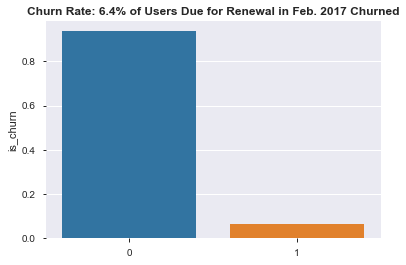

In [423]:
# Look at target variable's distribution:
target = 'is_churn'

sns.barplot(x=train_all[target].value_counts().index, 
            y=train_all[target].value_counts(normalize=True))
plt.title(f"Churn Rate: {train_all[target].value_counts(normalize=True).loc[1] * 100:.1f}% of Users Due for Renewal in Feb. 2017 Churned", fontweight="bold")
plt.show()

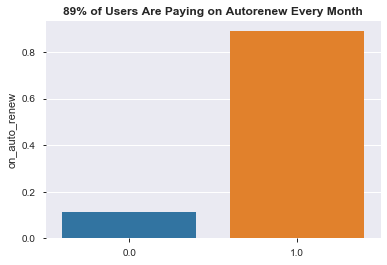

In [425]:
# Autorenew: % of customers who pay on autorenew:
autorenew_dist = train_imbalanced['on_auto_renew'].value_counts(normalize=True)
sns.barplot(x=autorenew_dist.index, 
            y=autorenew_dist);
plt.title(f"{autorenew_dist.loc[1] * 100:.0f}% of Users Are Paying on Autorenew Every Month", fontweight="bold")
plt.show()

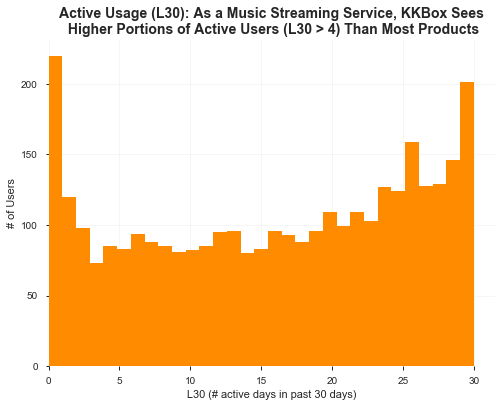

In [426]:
# L30 histogram (L30: an active usage metric that is # days active / last 30 days for each user, bucketed below):
plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')

plt.hist(train_imbalanced['active_days_L30_last_month'], bins=train_imbalanced['active_days_L30_last_month'].nunique(), color='darkorange')

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')
ax.set_xlim(0)

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Active Usage (L30): As a Music Streaming Service, KKBox Sees\n Higher Portions of Active Users (L30 > 4) Than Most Products", fontweight='bold', fontsize=14)
plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('# of Users')
plt.show()

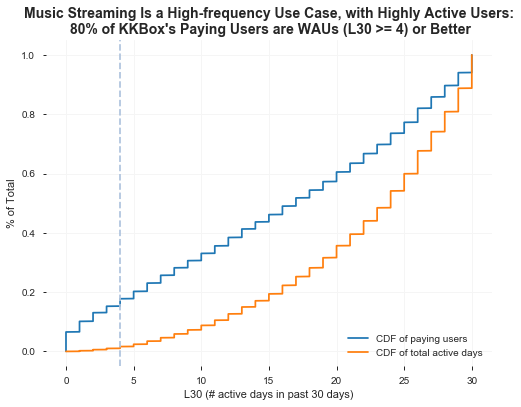

In [427]:
# CDF of # users vs. CDF of # of total active days in L30:
# --> to show us how many of KKBox's users drive (account for) the majority of total active KKBox usage
# L30 histogram (L30: an active usage metric that is # days active / last 30 days for each user, bucketed below):
plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')

L30_cdf_data = pd.DataFrame(train_imbalanced['active_days_L30_last_month'].copy().dropna().sort_values()).reset_index(drop=True)
L30_cdf_data['cumulative_users'] = L30_cdf_data.index + 1
L30_cdf_data['%_of_users'] = L30_cdf_data['cumulative_users'] / len(L30_cdf_data['cumulative_users'])
L30_cdf_data['cumulative_active_days'] = L30_cdf_data['active_days_L30_last_month'].cumsum()
L30_cdf_data['%_of_active_days'] = L30_cdf_data['cumulative_active_days'] / L30_cdf_data['active_days_L30_last_month'].sum()

# Plot the CDFs of L30 (# active days) last month for both # users and # active days:
plt.plot(L30_cdf_data['active_days_L30_last_month'], L30_cdf_data['%_of_users'])
plt.plot(L30_cdf_data['active_days_L30_last_month'], L30_cdf_data['%_of_active_days'])

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Music Streaming Is a High-frequency Use Case, with Highly Active Users:\n 80% of KKBox's Paying Users are WAUs (L30 >= 4) or Better", fontweight='bold', fontsize=14)
plt.axvline(x=28/7, linestyle='--', color='lightsteelblue')

plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('% of Total')
plt.legend(['CDF of paying users', 'CDF of total active days'], loc='best')
plt.show()

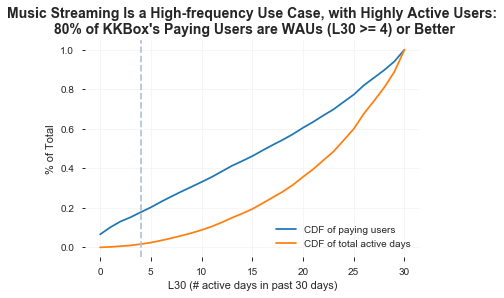

In [443]:
# Make a maximums-only copy of the cdf dataframe, solely for plotting 
# on a chart (i.e., keep only the maximums for each L30 value):
L30_cdf_data_for_charts = L30_cdf_data.groupby(by=['active_days_L30_last_month']).max()

# Plot the CDFs of L30 (# active days) last month for both # users and # active days:
plt.plot(L30_cdf_data_for_charts.index, L30_cdf_data_for_charts['%_of_users'])
plt.plot(L30_cdf_data_for_charts.index, L30_cdf_data_for_charts['%_of_active_days'])

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Music Streaming Is a High-frequency Use Case, with Highly Active Users:\n 80% of KKBox's Paying Users are WAUs (L30 >= 4) or Better", fontweight='bold', fontsize=14)
plt.axvline(x=28/7, linestyle='--', color='lightsteelblue')

plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('% of Total')
plt.legend(['CDF of paying users', 'CDF of total active days'], loc='best')
plt.show()

# **Feature Selection:**

**Feature Selection Method #1: Permutation Importances:**

In [505]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m2_rf = RandomForestClassifier(n_estimators=100, n_jobs=-2, random_state=42)
m2_rf.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-2, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [506]:
# Permutation importances:

# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_rf = PermutationImportance(
    m2_rf, 
    scoring='recall',  # Other options: 'neg_log_loss', 'recall', 'accuracy', ROC AUC ??
    n_iter=5, 
    random_state=42
)

permuter_rf.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [507]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_rf, 
    top=None, 
    feature_names=feature_names
)

In [508]:
# List of featured selected (criteria: permutation importance > 0):
features_selected_perm_importances = perm_importances_rf[perm_importances_rf > 0].index
features_selected_perm_importances

Index(['registered_via', 'is_DAU_last_6_months', 'cost_per_month',
       'gender_female', 'total_days_since_joined', 'is_WAU_last_6_months',
       'is_DAU_last_month', 'churn_returned_in_past', 'is_MAU_last_month',
       'age', 'total_mins_last_month', 'num_songs_started_last_6_months',
       'last_month_vs_6_month_avg', 'num_songs_finished_last_month',
       'on_auto_renew', 'payment_method_latest',
       'songs_percent_disliked_last_6_months'],
      dtype='object')

**Feature Selection Method #2: Recursive Feature Elimination:**

In [509]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=100, n_jobs=-2, random_state=42)
m3_gbt.fit(X_train_transformed, y_train)

# Initiate and fit the RFECV feature selector:
feature_selector_rfe = RFECV(estimator=m3_gbt, 
                         step=1, 
                         cv=StratifiedShuffleSplit(n_splits=5, 
                                                   train_size=0.8, 
                                                   random_state=42), 
                         scoring='recall', 
                         n_jobs=-2)
feature_selector_rfe.fit(X_train_transformed, y_train)

# X_rfe = feature_selector_rfe.transform(X_train_scaled)

# Performance on training data:
y_true_rfe_train = y_train
y_pred_rfe_train = feature_selector_rfe.predict(X_train_transformed)

print('Model performance on training set:\n')
print(f'Training set accuracy: {accuracy_score(y_true_rfe_train, y_pred_rfe_train):.3f}')
recall_rfe_train = recall_score(y_true_rfe_train, y_pred_rfe_train, average='micro')
print(f'Training set recall (TPR): {recall_rfe_train:.3f}\n')

# Apply to validation data and get score:
y_true_rfe_val = y_val
y_pred_rfe_val = feature_selector_rfe.predict(X_val_transformed)

print('Model performance on validation set:\n')
print(f'Validation set accuracy: {accuracy_score(y_true_rfe_val, y_pred_rfe_val):.3f}')
recall_rfe_val = recall_score(y_true_rfe_val, y_pred_rfe_val, average='binary')
print(f'Validation set recall (TPR): {recall_rfe_val:.3f}\n')

# X_rfe = feature_selector_rfe.transform(X_train_scaled)

Model performance on training set:

Training set accuracy: 0.786
Training set recall (TPR): 0.786

Model performance on validation set:

Validation set accuracy: 0.835
Validation set recall (TPR): 0.736



Optimal number of features : 8
Capture bulk of accuracy with: 7


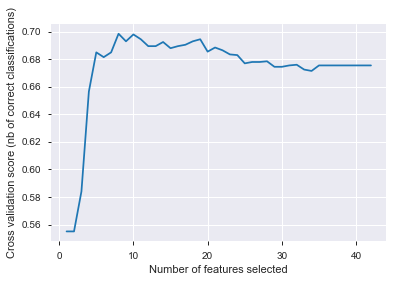

In [510]:
print("Optimal number of features : %d" % feature_selector_rfe.n_features_)
num_features_baseline = next(x for x, value in enumerate(feature_selector_rfe.grid_scores_) if value > 0.69)
print(f'Capture bulk of accuracy with: {num_features_baseline}')

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(feature_selector_rfe.grid_scores_) + 1), feature_selector_rfe.grid_scores_)
plt.show()

In [511]:
ranks_rfecv = pd.DataFrame(data=feature_selector_rfe.ranking_, index=X_train.columns, columns=['ranking'])
ranks_rfecv['include'] = feature_selector_rfe.support_
ranks_rfecv['grid_scores'] = feature_selector_rfe.grid_scores_
ranks_rfecv.sort_values(by=['ranking'], ascending=True)

ranking  include  grid_scores
payment_method_latest                       1     True       0.6755
total_days_since_joined                     1     True       0.6855
on_auto_renew                               1     True       0.6755
churned_any_in_past                         1     True       0.6850
is_WAU_last_month                           1     True       0.6725
cost_per_month                              1     True       0.6980
active_days_L30_last_month                  1     True       0.6925
is_MAU_last_month                           1     True       0.6830
last_month_vs_6_month_avg                   2    False       0.6755
is_DAU_last_6_months                        3    False       0.6850
active_days_L30_last_6_months_avg           4    False       0.6755
num_unique_last_month                       5    False       0.5550
age                                         6    False       0.6770
num_songs_listened_last_6_months            7    False       0.6755
gender_female                               8    False       0.6895
total_mins_last_month                       9    False       0.6780
num_songs_started_last_6_months            10    False       0.6780
total_mins_last_6_months                   11    False       0.5550
num_unique_last_6_months                   12    False       0.6945
num_songs_started_last_month               13    False       0.6565
songs_percent_loved_last_6_months          14    False       0.6745
num_songs_finished_last_month              15    False       0.6755
songs_percent_disliked_last_month          16    False       0.6930
num_songs_listened_last_month              17    False       0.6895
songs_affinity_nps_last_month              18    False       0.6755
songs_percent_disliked_last_6_months       19    False       0.6755
gender_male                                20    False       0.6930
avg_min_per_song                           21    False       0.6880
num_songs_finished_last_6_months           22    False       0.6745
city                                       23    False       0.6755
songs_percent_loved_last_month             24    False       0.6760
songs_affinity_nps_last_6_months           25    False       0.6945
registered_via                             26    False       0.5840
churn_returned_num_times                   27    False       0.6895
churned_full_num_times                     28    False       0.6985
last_6_months_avg_monthly_mins             29    False       0.6815
gender_nan                                 30    False       0.6715
churned_full_in_past                       31    False       0.6785
churn_returned_in_past                     32    False       0.6835
churned_any_num_times                      33    False       0.6905
is_DAU_last_month                          34    False       0.6865
is_WAU_last_6_months                       35    False       0.6885

In [512]:
feature_names = X_train.columns
features_selected_rfe = feature_names[feature_selector_rfe.support_].tolist()
features_selected_rfe

['churned_any_in_past',
 'cost_per_month',
 'active_days_L30_last_month',
 'total_days_since_joined',
 'is_MAU_last_month',
 'is_WAU_last_month',
 'on_auto_renew',
 'payment_method_latest']

**Final Features Selected:**

In [528]:
# Define final features and target, based on above findings re feature importances:
target = 'is_churn'

# Combine features selected by RFE and by permutation importances > 0:
features = set(features_selected_perm_importances)|(set(features_selected_rfe))
to_remove = set([
                 # Target variable:
                 target, 
                 
                 # Irrelevant information and/or no variance:
                 'msno', 'registration_init_time', 'gender', 
                 
                 # Far too many NaNs --> better to drop than impute:
                 # Removed: 'age' has >50% NaNs, but nonetheless helps our models a lot (esp. for TPR/recall), so 
                 # decided to keep despite the NaNs.
                 ])
features = list(features - to_remove)

# Features matrices and target vectors for train and val sets:
X_train = train[features]
y_train = train[target]
X_train_balanced = train[features]
y_train_balanced = train[target]
X_train_imbalanced = train_imbalanced[features]
y_train_imbalanced = train_imbalanced[target]
X_val = val[features]
y_val = val[target]
# X_test = test[features]  # [?? To do: Reinstate test here and everywhere above!! ??]

# # Check to make sure X matrices have the same numbers of columns:
# assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [533]:
X_train.shape, X_train_imbalanced.shape, X_val.shape, y_train.shape, y_val.shape
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((4000, 20), (4000, 20), (4000, 20), (4000,), (4000,))

In [534]:
features

['total_days_since_joined',
 'is_WAU_last_6_months',
 'is_DAU_last_month',
 'is_DAU_last_6_months',
 'registered_via',
 'churn_returned_in_past',
 'is_MAU_last_month',
 'age',
 'total_mins_last_month',
 'num_songs_started_last_6_months',
 'churned_any_in_past',
 'last_month_vs_6_month_avg',
 'is_WAU_last_month',
 'cost_per_month',
 'active_days_L30_last_month',
 'num_songs_finished_last_month',
 'on_auto_renew',
 'gender_female',
 'payment_method_latest',
 'songs_percent_disliked_last_6_months']

In [535]:
X_train.columns

Index(['total_days_since_joined', 'is_WAU_last_6_months', 'is_DAU_last_month',
       'is_DAU_last_6_months', 'registered_via', 'churn_returned_in_past',
       'is_MAU_last_month', 'age', 'total_mins_last_month',
       'num_songs_started_last_6_months', 'churned_any_in_past',
       'last_month_vs_6_month_avg', 'is_WAU_last_month', 'cost_per_month',
       'active_days_L30_last_month', 'num_songs_finished_last_month',
       'on_auto_renew', 'gender_female', 'payment_method_latest',
       'songs_percent_disliked_last_6_months'],
      dtype='object')

# **Baselines:**

### Baseline 1:  Dummy Model:  Majority Classifier:

In [536]:
train_all[target].value_counts(dropna=False, normalize=True)

0    0.936077
1    0.063923
Name: is_churn, dtype: float64

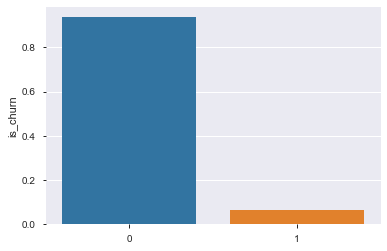

In [537]:
sns.barplot(x=train_all[target].value_counts(normalize=True).index, 
            y=train_all[target].value_counts(normalize=True));

In [538]:
majority_class = train_all[target].mode()[0]

In [539]:
# Get relevant score for our Baseline 1: Majority Classifier dummy model:
y_true_val = y_val
y_pred_b1_val = [majority_class] * len(y_val)

# Get confusion matrix:
cm_b1_val = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b1_val.loc['actual_1', 'pred_1']
FN = cm_b1_val.loc['actual_1', 'pred_0']
FP = cm_b1_val.loc['actual_0', 'pred_1']
TN = cm_b1_val.loc['actual_0', 'pred_0']

print('\nBaseline 1:  Majority Classifier Performance:\n')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
y_pred_b1_val_proba = np.full(shape=(len(y_val), 2), fill_value=[1.0, 0.0])
print(f'Log loss (negative): {log_loss(y_true_val, y_pred_b1_val_proba, eps=10**-15):.3f}')
cm_b1_val


Baseline 1:  Majority Classifier Performance:

Accuracy: 0.938
Recall : 0.000
False Negative Rate ("Miss Rate"): 1.000
Log loss (negative): 2.159


pred_0  pred_1
actual_0    3750       0
actual_1     250       0

In [540]:
# Confusion matrix, normalized:
cm_b1_val / cm_b1_val.sum().sum()

pred_0  pred_1
actual_0  0.9375     0.0
actual_1  0.0625     0.0

### Baseline 2:  Simple Single Decision Tree Classifier:

In [541]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    DecisionTreeClassifier(min_samples_leaf=2, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

print('\nBaseline #2: Single Decision Tree Classifier: Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_b2_train = y_train
y_pred_b2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_b2_train = pd.DataFrame(confusion_matrix(y_true_b2_train, y_pred_b2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_train.loc['actual_1', 'pred_1']
FN = cm_b2_train.loc['actual_1', 'pred_0']
FP = cm_b2_train.loc['actual_0', 'pred_1']
TN = cm_b2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_train, y_pred_b2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_train, y_pred_b2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_b2_train, y_pred_b2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_b2_train / cm_b2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_b2_train / cm_b2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_b2_val = y_val
y_pred_b2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_b2_val = pd.DataFrame(confusion_matrix(y_true_b2_val, y_pred_b2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_val.loc['actual_1', 'pred_1']
FN = cm_b2_val.loc['actual_1', 'pred_0']
FP = cm_b2_val.loc['actual_0', 'pred_1']
TN = cm_b2_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_val, y_pred_b2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_val, y_pred_b2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_b2_val, y_pred_b2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_b2_val / cm_b2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_b2_val / cm_b2_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Baseline #2: Single Decision Tree Classifier: Performance:

TRAINING SET:

Accuracy: 0.926
Recall : 0.881
"Miss Rate" (FNR): 0.118
Log loss (negative): 0.121


VALIDATION SET:

Accuracy: 0.753
Recall : 0.664
"Miss Rate" (FNR): 0.336
Log loss (negative): 6.948

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.71125  0.22625
actual_1  0.02100  0.04150

In [542]:
# # Plot tree
# # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# import graphviz
# from sklearn.tree import export_graphviz

# b2_dt_estimator = pipeline.named_steps['decisiontreeclassifier']
# encoder = pipeline.named_steps['ordinalencoder']
# encoded_columns = encoder.transform(X_val).columns

# dot_data = export_graphviz(b2_dt_estimator, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=encoded_columns,
#                            class_names=b2_dt_estimator.classes_, 
#                            impurity=False, 
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))

In [543]:
# # Feature Importances:
# b2_dt_feat_importances = pd.Series(b2_dt_estimator.feature_importances_, encoded_columns)

# # Plot on chart:
# n = len(encoded_columns)
# plt.figure(figsize=(10, n/2))
# b2_dt_feat_importances.sort_values().plot.barh(color='grey')
# plt.title('Feature Importances: Baseline #2: Single DecisionTree Model')
# plt.show()

# **Models/Predictions:**

### Model 1:  Logistic Regression Classifier w/ Cross-validation:

In [544]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='ovr', 
                         class_weight='balanced', 
                         cv=StratifiedKFold(n_splits=5), 
                         scoring='recall', 
                         solver='lbfgs', 
                         n_jobs=-2, 
                         random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)


print('\nModel #1: Linear Model: Logistic Regression w/ CV Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m1_train = y_train
y_pred_m1_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m1_train = pd.DataFrame(confusion_matrix(y_true_m1_train, y_pred_m1_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_train.loc['actual_1', 'pred_1']
FN = cm_m1_train.loc['actual_1', 'pred_0']
FP = cm_m1_train.loc['actual_0', 'pred_1']
TN = cm_m1_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_train, y_pred_m1_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_train, y_pred_m1_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m1_train, y_pred_m1_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m1_train / cm_m1_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m1_train / cm_m1_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m1_val = y_val
y_pred_m1_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m1_val = pd.DataFrame(confusion_matrix(y_true_m1_val, y_pred_m1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_val.loc['actual_1', 'pred_1']
FN = cm_m1_val.loc['actual_1', 'pred_0']
FP = cm_m1_val.loc['actual_0', 'pred_1']
TN = cm_m1_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_val, y_pred_m1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_val, y_pred_m1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m1_val, y_pred_m1_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m1_val / cm_m1_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m1_val / cm_m1_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Model #1: Linear Model: Logistic Regression w/ CV Performance:

TRAINING SET:

Accuracy: 0.753
Recall : 0.643
"Miss Rate" (FNR): 0.356
Log loss (negative): 0.580


VALIDATION SET:

Accuracy: 0.855
Recall : 0.672
"Miss Rate" (FNR): 0.328
Log loss (negative): 0.570

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.81325  0.12425
actual_1  0.02050  0.04200

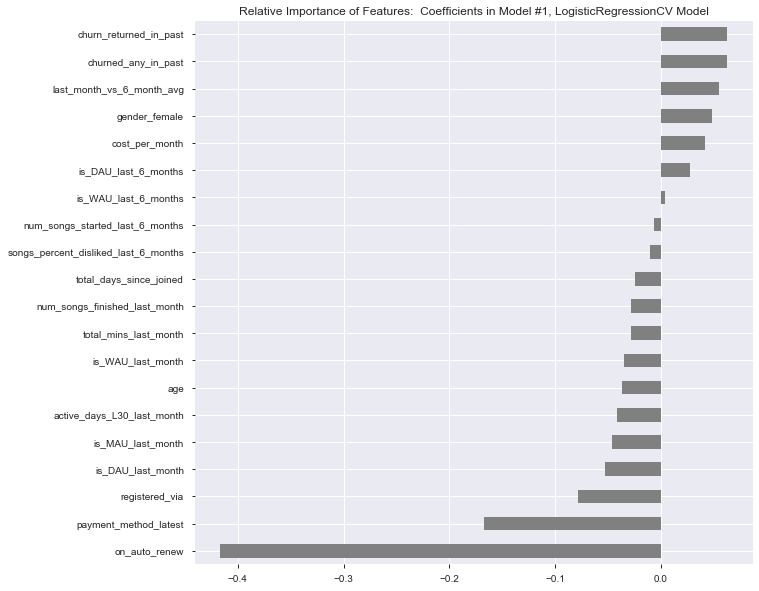

In [545]:
# Feature importances:  Get coefficients of LogisticRegressionCV model to see 
# which features have more of an impact on the model's predictions:
%matplotlib inline
import matplotlib.pyplot as plt

m1_logregcv_coeffs = pipeline.named_steps['logisticregressioncv'].coef_[0]
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients_table = pd.Series(m1_logregcv_coeffs, encoded_columns)

# Plot on chart:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
coefficients_table.sort_values().plot.barh(color='grey')
plt.title('Relative Importance of Features:  Coefficients in Model #1, LogisticRegressionCV Model')
plt.show()

### Model 2: RandomForest Classifier:

In [546]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('\nModel #2: RandomForestClassifier Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier Performance:

TRAINING SET:

Accuracy: 0.967
Recall : 0.954
"Miss Rate" (FNR): 0.046
Log loss (negative): 0.176

VALIDATION SET:

Accuracy: 0.826
Recall : 0.724
"Miss Rate" (FNR): 0.276
Log loss (negative): 0.570

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.78075  0.15675
actual_1  0.01725  0.04525

**RandomForest w/ Optimized Hyperparameters:**

In [547]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m2_rf = RandomForestClassifier(n_estimators=100, n_jobs=-2, random_state=42)

# Make dict with range of class_weights params to try, including None:
class_weight_balance = train_imbalanced[target].value_counts(normalize=True)[0] / train_imbalanced[target].value_counts(normalize=True)[1]
class_weight_0s_weights = np.linspace(0.5, class_weight_balance * 1.5, num=50)
class_weights_params = [None, 'balanced']
for item in range(0, len(class_weight_0s_weights)):
    class_weights_params.append({0:class_weight_0s_weights[item], 1:1})

param_distributions_rf = {
    'class_weight': class_weights_params, 
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100], 
    'min_samples_leaf': sp_randint(1, 10), 
    'bootstrap': [True, False], 
    'criterion': ['gini', 'entropy'], 
    'warm_start': [False, True]
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_rf = RandomizedSearchCV(
    m2_rf, 
    param_distributions=param_distributions_rf, 
    n_iter=250, 
    scoring='recall',  # Other options: 'recall', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_rf.fit(X_train_transformed, y_train)

# Show best estimator/params:
random_search_rf.best_estimator_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-2)]: Done 750 out of 750 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=False, class_weight={0: 0.5, 1: 1},
                       criterion='entropy', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=9,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-2, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [548]:
# Show all of the randomized search cross-validation results: 
pd.DataFrame(random_search_rf.cv_results_).sort_values(by='mean_test_score').T

65   \
mean_fit_time                                                    0.293506   
std_fit_time                                                    0.0213622   
mean_score_time                                                  0.116927   
std_score_time                                                 0.00830983   
param_bootstrap                                                     False   
param_class_weight                          {0: 10.568436397115237, 1: 1}   
param_criterion                                                      gini   
param_max_depth                                                         2   
param_min_samples_leaf                                                  5   
param_warm_start                                                     True   
params                  {'bootstrap': False, 'class_weight': {0: 10.56...   
split0_test_score                                                       0   
split1_test_score                                                       0   
split2_test_score                                                       0   
mean_test_score                                                         0   
std_test_score                                                          0   
rank_test_score                                                       244   
split0_train_score                                                      0   
split1_train_score                                                      0   
split2_train_score                                                      0   
mean_train_score                                                        0   
std_train_score                                                         0   

                                                                      158  \
mean_fit_time                                                    0.410039   
std_fit_time                                                    0.0479733   
mean_score_time                                                    0.1152   
std_score_time                                                 0.00321475   
param_bootstrap                                                      True   
param_class_weight                           {0: 8.051327297836428, 1: 1}   
param_criterion                                                   entropy   
param_max_depth                                                         2   
param_min_samples_leaf                                                  3   
param_warm_start                                                    False   
params                  {'bootstrap': True, 'class_weight': {0: 8.0513...   
split0_test_score                                                       0   
split1_test_score                                                       0   
split2_test_score                                                       0   
mean_test_score                                                         0   
std_test_score                                                          0   
rank_test_score                                                       244   
split0_train_score                                                      0   
split1_train_score                                                      0   
split2_train_score                                                      0   
mean_train_score                                                        0   
std_train_score                                                         0   

                                                                      3    \
mean_fit_time                                                    0.374399   
std_fit_time                                                   0.00506387   
mean_score_time                                                   0.10396   
std_score_time                                                0.000376776   
param_bootstrap                                                      True   
param_class_weight                           {0: 8.4708454810495

In [549]:
# Set our random forest model as the estimator with best hyperparameters from the randomized search:
m2_rf = clone(random_search_rf.best_estimator_)

m2_rf.fit(X_train_transformed, y_train)

# Get and print model performance:
print('\nModel #2: RandomForestClassifier w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = m2_rf.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = random_search_rf.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = m2_rf.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = m2_rf.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier w/ Optimized Hyperparameters:

TRAINING SET:

Accuracy: 0.845
Recall : 0.964
"Miss Rate" (FNR): 0.036
Log loss (negative): 0.382

VALIDATION SET:

Accuracy: 0.654
Recall : 0.844
"Miss Rate" (FNR): 0.156
Log loss (negative): 0.663

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.60175  0.33575
actual_1  0.00975  0.05275

In [550]:
m2_rf

RandomForestClassifier(bootstrap=False, class_weight={0: 0.5, 1: 1},
                       criterion='entropy', max_depth=70, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=9,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-2, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

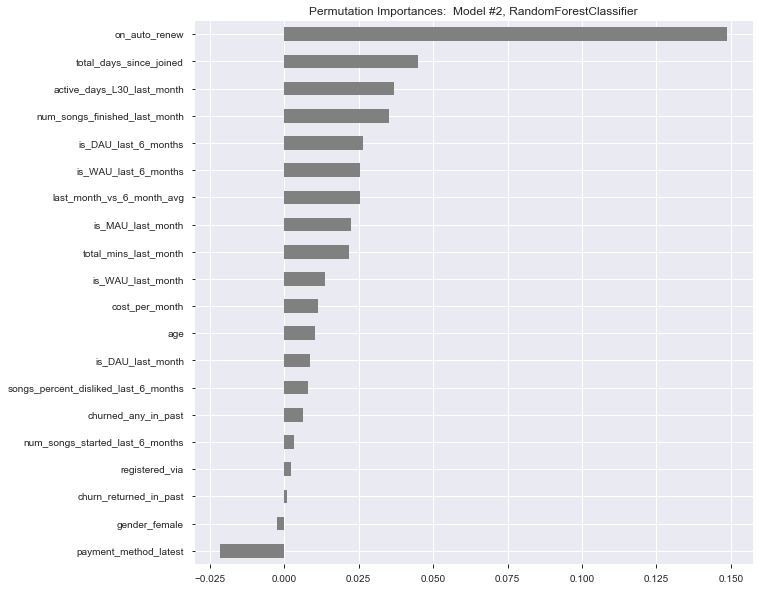

In [551]:
# Permutation importances:

# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_rf = PermutationImportance(
    m2_rf, 
    scoring='recall',  # Other options: 'neg_log_loss', 'recall', 'accuracy', ROC AUC ??
    n_iter=5, 
    random_state=42
)

permuter_rf.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_rf = pd.Series(permuter_rf.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_rf.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #2, RandomForestClassifier')
plt.show()

In [552]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_rf, 
    top=None, 
    feature_names=feature_names
)

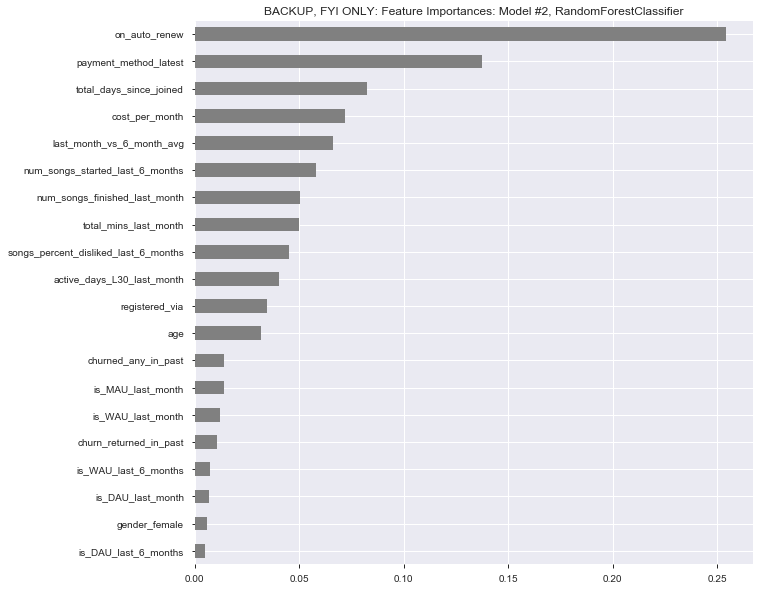

In [553]:
# BACKUP, FYI ONLY: Raw feature importances from model:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns
feat_importances_rf = pd.Series(m2_rf.feature_importances_, encoded_columns)

# Plot feature importances:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_rf.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Feature Importances: Model #2, RandomForestClassifier')
plt.show()

### Model 3:  Gradient-boosted Trees (Ensemble)

In [554]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=100, n_jobs=-2, random_state=42)
m3_gbt.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3: Gradient-boosted Trees Performance:

TRAINING SET:

Accuracy: 0.793
Recall : 0.725
"Miss Rate" (FNR): 0.275
Log loss (negative): 0.447


VALIDATION SET:

Accuracy: 0.840
Recall : 0.720
"Miss Rate" (FNR): 0.280
Log loss (negative): 0.471

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.7950  0.1425
actual_1  0.0175  0.0450

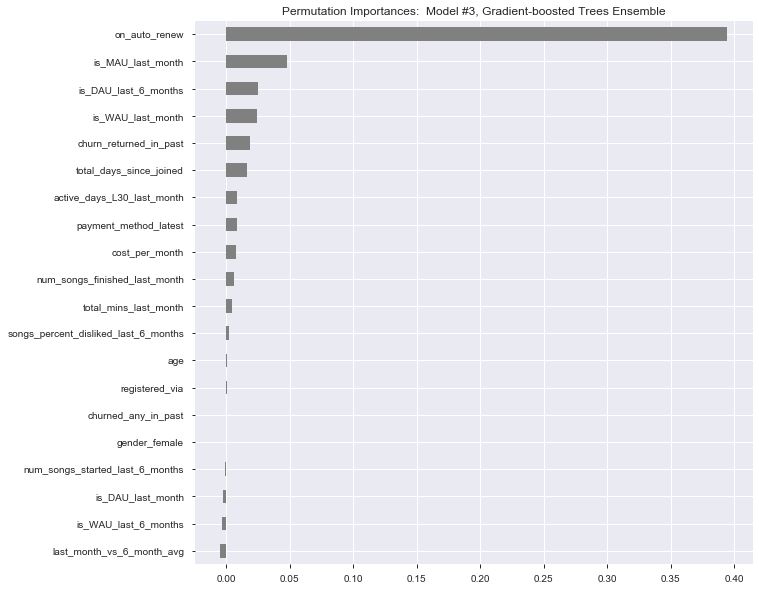

In [555]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_gbt = PermutationImportance(
    m3_gbt, 
    scoring='recall',  # OR 'neg_log_loss'
    n_iter=5, 
    random_state=42
)

permuter_gbt.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_gbt = pd.Series(permuter_gbt.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_gbt.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [556]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_gbt, 
    top=None, 
    feature_names=feature_names
)

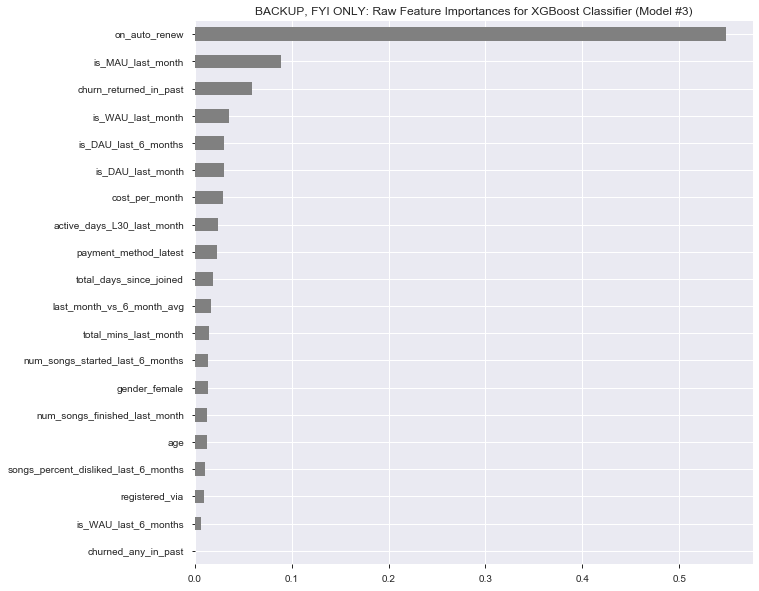

In [557]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_gbt = pd.Series(m3_gbt.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_gbt.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for XGBoost Classifier (Model #3)')
plt.show()

### Hyperparameter optimization:

In [558]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=100, n_jobs=-2, random_state=42)

# Range of scale_pos_weight (weighting of positive class) params to try:
scale_pos_weight = train_imbalanced[target].value_counts(normalize=True)[1] / train_imbalanced[target].value_counts(normalize=True)[0]
scale_pos_weight_params = np.linspace(scale_pos_weight * 0.5, scale_pos_weight * 20, num=100)

param_distributions_gbt = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 70, 90, 110], 
    'learning_rate': sp_uniform(0, 0.60), 
    'min_child_weight': sp_uniform(1, 10), 
    'scale_pos_weight': scale_pos_weight_params
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_gbt = RandomizedSearchCV(
    m3_gbt, 
    param_distributions=param_distributions_gbt, 
    n_iter=250, 
    scoring='recall',  # Best options: 'recall', 'neg_log_loss', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_gbt.fit(X_train_transformed, y_train)

# Show best estimator w/ best hyperparams found:
random_search_gbt.best_estimator_

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 750 out of 750 | elapsed:  2.4min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05870049639060088, max_delta_step=0, max_depth=30,
              min_child_weight=9.069129770507795, missing=None,
              n_estimators=100, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1.424745581146224, seed=None,
              silent=None, subsample=1, verbosity=1)

In [559]:
# Show all randomized search CV results:
pd.DataFrame(random_search_gbt.cv_results_).sort_values(by='mean_test_score').T

105  \
mean_fit_time                                                    0.411855   
std_fit_time                                                    0.0304439   
mean_score_time                                                0.00352399   
std_score_time                                                0.000873906   
param_learning_rate                                            0.00918272   
param_max_depth                                                        45   
param_min_child_weight                                            6.03136   
param_scale_pos_weight                                          0.0356186   
params                  {'learning_rate': 0.00918272417423085, 'max_de...   
split0_test_score                                                       0   
split1_test_score                                                       0   
split2_test_score                                                       0   
mean_test_score                                                         0   
std_test_score                                                          0   
rank_test_score                                                       250   
split0_train_score                                                      0   
split1_train_score                                                      0   
split2_train_score                                                      0   
mean_train_score                                                        0   
std_train_score                                                         0   

                                                                      44   \
mean_fit_time                                                    0.528678   
std_fit_time                                                    0.0101468   
mean_score_time                                                0.00533835   
std_score_time                                                0.000874544   
param_learning_rate                                             0.0308873   
param_max_depth                                                         6   
param_min_child_weight                                            4.45071   
param_scale_pos_weight                                          0.0356186   
params                  {'learning_rate': 0.03088725074999361, 'max_de...   
split0_test_score                                                       0   
split1_test_score                                               0.0764618   
split2_test_score                                               0.0405405   
mean_test_score                                                     0.039   
std_test_score                                                  0.0312422   
rank_test_score                                                       249   
split0_train_score                                                      0   
split1_train_score                                              0.0742686   
split2_train_score                                              0.0389805   
mean_train_score                                                0.0377497   
std_train_score                                                 0.0303325   

                                                                      20   \
mean_fit_time                                                    0.546719   
std_fit_time                                                    0.0837387   
mean_score_time                                                0.00718896   
std_score_time                                                0.000754945   
param_learning_rate                                             0.0991602   
param_max_depth                                                         8   
param_min_child_weight                                            5.23401   
param_scale_pos_weight                                          0.0356186   
params                  {'learning_rate': 0.0991601634378015, 'max_dep...   
split0_test_score                                               

In [560]:
random_search_gbt.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05870049639060088, max_delta_step=0, max_depth=30,
              min_child_weight=9.069129770507795, missing=None,
              n_estimators=100, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1.424745581146224, seed=None,
              silent=None, subsample=1, verbosity=1)

In [561]:
# Set our XGBoost model as the estimator with best hyperparameters from the randomized search:
m3_gbt_tuned = clone(random_search_gbt.best_estimator_)

m3_gbt_tuned.fit(X_train_transformed, y_train)

# Get and print model performance:
print('\nModel #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt_tuned.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt_tuned.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt_tuned.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt_tuned.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:

TRAINING SET:

Accuracy: 0.881
Recall : 0.892
"Miss Rate" (FNR): 0.108
Log loss (negative): 0.317


VALIDATION SET:

Accuracy: 0.786
Recall : 0.812
"Miss Rate" (FNR): 0.188
Log loss (negative): 0.558

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.73525  0.20225
actual_1  0.01175  0.05075

### Early stopping (for n_estimators):

In [562]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

# Change n_estimators max. to 1000 for early stopping (below):
m3_gbt_tuned_early = clone(m3_gbt_tuned)
m3_gbt_tuned_early = m3_gbt_tuned_early.set_params(n_estimators=1000)

eval_set = [(X_train_transformed, y_train), 
           (X_val_transformed, y_val)]

m3_gbt_tuned_early.fit(X_train_transformed, 
           y_train, 
           eval_set=eval_set, 
           eval_metric='auc',  # Options: logloss, auc, (no recall...) (https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
           verbose=True, 
           early_stopping_rounds=100)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt_tuned_early.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt_tuned_early.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------

# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt_tuned_early.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt_tuned_early.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()

[0]	validation_0-auc:0.858845	validation_1-auc:0.833043
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.869379	validation_1-auc:0.839386
[2]	validation_0-auc:0.869551	validation_1-auc:0.842317
[3]	validation_0-auc:0.87109	validation_1-auc:0.845101
[4]	validation_0-auc:0.877143	validation_1-auc:0.847812
[5]	validation_0-auc:0.878375	validation_1-auc:0.846483
[6]	validation_0-auc:0.880834	validation_1-auc:0.848143
[7]	validation_0-auc:0.885232	validation_1-auc:0.850234
[8]	validation_0-auc:0.887398	validation_1-auc:0.850146
[9]	validation_0-auc:0.888544	validation_1-auc:0.848125
[10]	validation_0-auc:0.891156	validation_1-auc:0.849599
[11]	validation_0-auc:0.893028	validation_1-auc:0.849633
[12]	validation_0-auc:0.893521	validation_1-auc:0.850089
[13]	validation_0-auc:0.895521	validation_1-auc:0.851874
[14]	validation_0-auc:0.896585	validation_1-auc:0.85281

[141]	validation_0-auc:0.972591	validation_1-auc:0.854115
[142]	validation_0-auc:0.972826	validation_1-auc:0.853901
[143]	validation_0-auc:0.972957	validation_1-auc:0.853753
[144]	validation_0-auc:0.973218	validation_1-auc:0.854127
[145]	validation_0-auc:0.973536	validation_1-auc:0.854356
[146]	validation_0-auc:0.973747	validation_1-auc:0.854191
[147]	validation_0-auc:0.973962	validation_1-auc:0.853984
[148]	validation_0-auc:0.974216	validation_1-auc:0.853872
[149]	validation_0-auc:0.974301	validation_1-auc:0.853971
[150]	validation_0-auc:0.974696	validation_1-auc:0.854055
[151]	validation_0-auc:0.974878	validation_1-auc:0.853822
[152]	validation_0-auc:0.974986	validation_1-auc:0.854689
[153]	validation_0-auc:0.975282	validation_1-auc:0.854405
[154]	validation_0-auc:0.975578	validation_1-auc:0.854365
[155]	validation_0-auc:0.975746	validation_1-auc:0.854446
[156]	validation_0-auc:0.97585	validation_1-auc:0.854734
[157]	validation_0-auc:0.976064	validation_1-auc:0.854812
[158]	validatio

pred_0   pred_1
actual_0  0.73600  0.20150
actual_1  0.01175  0.05075

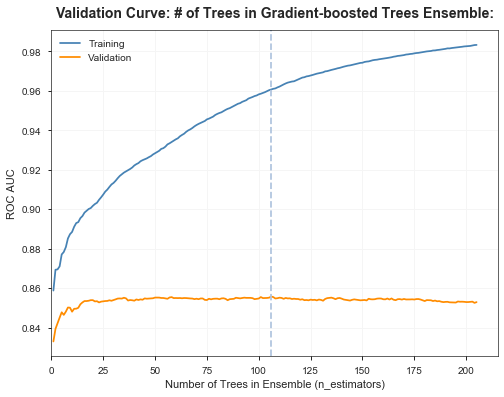

In [563]:
# Validation curve of early stopping results from above:
early_stopping_results = m3_gbt_tuned_early.evals_result()
train_error = early_stopping_results['validation_0']['auc']
val_error = early_stopping_results['validation_1']['auc']

best_num_estimators = m3_gbt_tuned_early.best_ntree_limit

# Plot these results as a validation curve:

# x-values: Epoch #:
epoch_num = list(range(1, len(train_error) + 1))

# Plot train and val errors:

plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')
plt.plot(epoch_num, train_error, label='Training', color='steelblue')
plt.plot(epoch_num, val_error, label='Validation', color='darkorange')

plt.title('Validation Curve: # of Trees in Gradient-boosted Trees Ensemble:', 
          y=1.02, 
          fontsize=14, 
          fontweight='bold')
plt.xlabel('Number of Trees in Ensemble (n_estimators)')
plt.ylabel('ROC AUC')
plt.legend()

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')
ax.set_xlim(0)

# Show or hide borders:
# ax.spines['left'].set_linewidth(0.75)
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')

# ax.spines['bottom'].set_linewidth(0.75)
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')

for spine in ax.spines.values():
    spine.set_linewidth(0.6)
    spine.set_color('black')
    spine.set_visible(True)

# Line showing selected best number of trees (n_estimators) to use:
ax.axvline(x=best_num_estimators, linestyle='--', color='lightsteelblue')

plt.show()

## Recall-Accuracy Tradeoff: A Cost Function Based on KKBox's Actual Business Model:

In [564]:
# Define appendix variables:
USD_TWD = 30.91  # USD/TWD exchange rate as of 2017/02/27, the end of the training dataset. (Source: Yahoo! Finance)

In [565]:
# Define business-related metrics for KKBox:

# Monthly subscription cost (regular vs. discounted):
metrics_monthly_cost_full = train_imbalanced['cost_per_month'].mode().iloc[0]
metrics_monthly_cost_discounted = train_imbalanced['cost_per_month'].value_counts(dropna=False, normalize=True).sort_values(ascending=False).index[1]

# Monthly churn and customer LTV (lifetime value) metrics:
metrics_monthly_churn = train_imbalanced[target].value_counts(dropna=False, normalize=True).loc[1]
metrics_avg_customer_lifetime = 1 / metrics_monthly_churn
metrics_customer_LTV_revenue = metrics_avg_customer_lifetime * metrics_monthly_cost_full
metrics_GM = 0.25  # Assumption: Gross margin of 25% in long term. Reasoning (Comps): Spotify's gross margin has hovered at 25-26% throughout 2019; Tencent Music's GM has hovered at 33-35% in 2019 (was 38% for FY2018). (Sources: Spotify and Tencent Music public financial reports)
metrics_customer_LTV_GM = metrics_customer_LTV_revenue * metrics_GM
metrics_customers_due_for_renewal_monthly = 2000000  # Note: Only 1 mn are covered in the KKBox dataset, but KKBox announced it had 2 mn paying users in 2014, essentially all of whom were on monthy subscriptions. Considering its continued strength in Taiwan through 2017/18 and its smaller user gains in HK, Singapore and Japan, we can assume KKBox still had at least 2 mn paying subscribers in Q1 2017 (but probably not too many more, given it had already thoroughly penetrated the Taiwanese population by 2014, and failed to gain material users in other countries it expanded to after that.)

# Assumption: Avg. actual (TWD) KKBox revenue gain from +1 TRUE positive in our predictions:
assumption_percent_converted_to_discount = 0.50  # Assumption: 50% of likely-to-churn customers offered the discount will "convert" (accept the discount instead of cancelling).
assumption_discount_num_months = 3
assumption_percent_retained_after_discount_period = 0.50  # Assumption: 50% of the customers who accepted the discount (so 50% * 50% = 25% of all customers)
assumption_percent_retained = assumption_percent_converted_to_discount * assumption_percent_retained_after_discount_period
assumption_percent_discount_only = assumption_percent_converted_to_discount - assumption_percent_retained

assumption_avg_months_continued_after_discount = round(metrics_avg_customer_lifetime / 2, 0)
assumption_LTV_of_discount_only_customer = assumption_discount_num_months * metrics_monthly_cost_discounted
assumption_LTV_of_fully_retained_customer = assumption_LTV_of_discount_only_customer + assumption_avg_months_continued_after_discount * metrics_monthly_cost_full
assumption_avg_gain_per_1_TP = (assumption_percent_retained * assumption_LTV_of_fully_retained_customer) + (assumption_percent_discount_only * assumption_LTV_of_discount_only_customer)

# Assumption: Avg. actual (TWD) cost to KKBox of +1 false positive in our model's predictions:
assumptions_lost_revenue_from_discount = assumption_discount_num_months * (metrics_monthly_cost_full - metrics_monthly_cost_discounted)
assumptions_customer_support_hourly_pay = 60000 * USD_TWD / (50 * 5 * 8)  # Assumptions: $60k USD avg. annual salary; avg. of 2000 yearly hours worked (50 weeks * 5 workdays * 8 hours/workday)
assumptions_customer_support_hours_per_target_customer = (0 * 0.50 + 5/60 * 0.50)  # Assumptions: 50% of customers require 0 mins. of customer support staff time, but 50% of customers require an avg. of 5 mins. each (~1 customer support chat or phone call).
assumptions_customer_support_cost = assumptions_customer_support_hourly_pay * assumptions_customer_support_hours_per_target_customer
assumption_avg_cost_per_1_FP = assumptions_customer_support_cost + assumptions_lost_revenue_from_discount

# How we should calibrate our model in order to maximize KKBox profits:
# Based on the above assumptions, what is the max. # of false positives (FPs) we can accept 
# per +1 true positive (TP) our model identifies (same ratio for %s):
max_acceptable_FPs_per_TP = assumption_avg_gain_per_1_TP / assumption_avg_cost_per_1_FP

In [566]:
# List Churn and Unit Metrics for Reference:
print('EXISTING CUSTOMERS:')
print(f"Subscription cost, monthly: TWD {metrics_monthly_cost_full:.0f} (USD ${metrics_monthly_cost_full / USD_TWD:.0f})")
print(f"Subscription cost (discounted): TWD {metrics_monthly_cost_discounted:.0f} (USD ${metrics_monthly_cost_discounted / USD_TWD:.0f})")
print(f"Customers due for renewal per month: {metrics_customers_due_for_renewal_monthly / 10**6:.1f} mn")
print(f"Customer churn, monthly: {metrics_monthly_churn * 100:.1f}%")
print(f"Avg. customer lifetime: {metrics_avg_customer_lifetime:.0f} months")
print(f"Avg. LTV* revenue: TWD {metrics_customer_LTV_revenue:.0f} (USD ${metrics_customer_LTV_revenue / USD_TWD:.0f})")
print(f"Avg. LTV gross margin**: TWD {metrics_customer_LTV_GM:.0f} (USD ${metrics_customer_LTV_GM / USD_TWD:.0f})")

print("VALUE OF ADDITIONAL RETAINED CUSTOMERS (EST.):")
print(f"LTV of retaining a likely-to-churn customer: TWD {assumption_LTV_of_fully_retained_customer:.0f} (USD ${assumption_LTV_of_fully_retained_customer / USD_TWD:.0f})\n")

print("MODEL CALIBRATION: ACTUAL DOLLAR-VALUE FOR KKBOX")
print(f"Gain per 1 TP identified (est.): TWD {assumption_avg_gain_per_1_TP:.0f} (USD ${assumption_avg_gain_per_1_TP / USD_TWD:.0f})")
print(f"Cost per 1 FP from our model (est.): TWD {assumption_avg_cost_per_1_FP:.0f} (USD ${assumption_avg_cost_per_1_FP / USD_TWD:.0f})")
print(f"Max. # of FPs KKBox can accept per +1 TP we identify: +{max_acceptable_FPs_per_TP:.1f} FPs\n")

print("*LTV: Customer lifetime value")
print(f"**Assumption: Long term GM of {metrics_GM * 100:.0f}%, similar to Spotify.\n")

EXISTING CUSTOMERS:
Subscription cost, monthly: TWD 149 (USD $5)
Subscription cost (discounted): TWD 99 (USD $3)
Customers due for renewal per month: 2.0 mn
Customer churn, monthly: 6.7%
Avg. customer lifetime: 15 months
Avg. LTV* revenue: TWD 2241 (USD $72)
Avg. LTV gross margin**: TWD 560 (USD $18)
VALUE OF ADDITIONAL RETAINED CUSTOMERS (EST.):
LTV of retaining a likely-to-churn customer: TWD 1489 (USD $48)

MODEL CALIBRATION: ACTUAL DOLLAR-VALUE FOR KKBOX
Gain per 1 TP identified (est.): TWD 446 (USD $14)
Cost per 1 FP from our model (est.): TWD 189 (USD $6)
Max. # of FPs KKBox can accept per +1 TP we identify: +2.4 FPs

*LTV: Customer lifetime value
**Assumption: Long term GM of 25%, similar to Spotify.



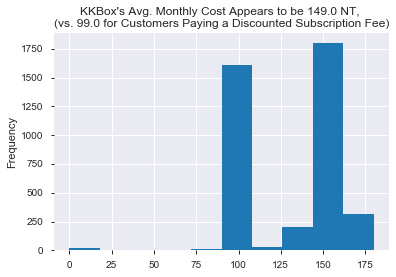

In [567]:
# Chart showing most common monthly avg. costs paid:
train_imbalanced['cost_per_month'].plot.hist()
plt.title(f"KKBox's Avg. Monthly Cost Appears to be {metrics_monthly_cost_full} NT, \n(vs. {metrics_monthly_cost_discounted} for Customers Paying a Discounted Subscription Fee)")
plt.show()

## Recall-Accuracy Tradeoff: Performance Metrics by Class Weighting:

In [568]:
# Function that makes a dataframe of key performance metrics for a range of 
# scale_pos_weights (class weights) values:
def get_performance_metrics(X_to_evaluate, y_true, estimator, weights, X_train, y_train):
    from sklearn.base import clone
    
    metrics_columns = ['accuracy', 'neg_log_loss', 'recall', 'miss_rate_FNR', 'precision', 'roc_auc', 'balanced_accuracy']
    
    df = pd.DataFrame(columns=metrics_columns, dtype=np.float64)
    estimator = clone(estimator)
    
    for weight in weights:
        estimator = estimator.set_params(scale_pos_weight=weight)
        estimator.fit(X_train, y_train)

        # Get performance metrics at x scale_pos_weights value, and add dataframe:
        y_pred_temp = estimator.predict(X_to_evaluate)
        y_pred_temp_proba = estimator.predict_proba(X_to_evaluate)[:, -1]

        df.loc[weight, 'accuracy'] = accuracy_score(y_true, y_pred_temp)
        df.loc[weight, 'neg_log_loss'] = log_loss(y_true, y_pred_temp_proba, eps=10**-15)
        df.loc[weight, 'recall'] = recall_score(y_true, y_pred_temp, average='binary')
        df.loc[weight, 'precision'] = precision_score(y_true, y_pred_temp)
        df.loc[weight, 'roc_auc'] = roc_auc_score(y_true, y_pred_temp_proba)
        df.loc[weight, 'balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred_temp)
    
    df.loc[:, 'miss_rate_FNR'] = 1 - df.loc[:, 'recall']
    
    df.index.name = "scale_pos_weight"
    
    return df

In [569]:
# Get key performance metrics for train_imbalanced and val for the below range of 
# scale_pos_weights values, by implementing the above function:

weights = np.linspace(scale_pos_weight / 4, scale_pos_weight * 20, num=100)

# [?? To do: Re-implement below line (train_imbalanced), but with cross-validation ??]
reweighting_scores_train_imbalanced = get_performance_metrics(X_train_imbalanced_transformed, y_train_imbalanced, m3_gbt_tuned_early, weights, X_train_transformed, y_train)
# reweighting_scores_val = get_performance_metrics(X_val_transformed, y_val, m3_gbt_tuned_early, weights, X_train_transformed, y_train)

In [570]:
reweighting_scores_train_imbalanced.head(50)

accuracy  neg_log_loss    recall  miss_rate_FNR  precision  \
scale_pos_weight                                                               
0.017809           0.93475      0.212168  0.026316       0.973684   0.777778   
0.032021           0.93925      0.185696  0.195489       0.804511   0.641975   
0.046232           0.93775      0.179362  0.304511       0.695489   0.558621   
0.060444           0.93475      0.184632  0.375940       0.624060   0.512821   
0.074655           0.93125      0.190915  0.432331       0.567669   0.481172   
0.088867           0.93050      0.199825  0.473684       0.526316   0.477273   
0.103078           0.92400      0.208803  0.500000       0.500000   0.437500   
0.117290           0.92050      0.218161  0.526316       0.473684   0.421687   
0.131501           0.91700      0.227903  0.552632       0.447368   0.408333   
0.145713           0.91300      0.238869  0.567669       0.432331   0.393229   
0.159924           0.91100      0.247803  0.578947       0.421053   0.386935   
0.174136           0.90475      0.259686  0.593985       0.406015   0.366589   
0.188347           0.90600      0.269362  0.605263       0.394737   0.372685   
0.202559           0.90150      0.279329  0.605263       0.394737   0.357778   
0.216770           0.89500      0.287258  0.612782       0.387218   0.339583   
0.230981           0.89375      0.296439  0.631579       0.368421   0.339394   
0.245193           0.88900      0.305633  0.635338       0.364662   0.327519   
0.259404           0.88575      0.314883  0.627820       0.372180   0.318095   
0.273616           0.88550      0.322043  0.646617       0.353383   0.320896   
0.287827           0.87800      0.330389  0.650376       0.349624   0.304577   
0.302039           0.87775      0.335447  0.657895       0.342105   0.305410   
0.316250           0.87225      0.342546  0.657895       0.342105   0.294118   
0.330462           0.86775      0.350820  0.657895       0.342105   0.285481   
0.344673           0.86925      0.357063  0.665414       0.334586   0.289689   
0.358885           0.86700      0.360868  0.665414       0.334586   0.285484   
0.373096           0.86300      0.369117  0.672932       0.327068   0.279687   
0.387308           0.86350      0.370488  0.669173       0.330827   0.279874   
0.401519           0.86000      0.376145  0.665414       0.334586   0.273148   
0.415731           0.86025      0.384805  0.684211       0.315789   0.277017   
0.429942           0.85975      0.385886  0.676692       0.323308   0.274809   
0.444154           0.85550      0.391574  0.672932       0.327068   0.267164   
0.458365           0.85400      0.397980  0.680451       0.319549   0.266176   
0.472577           0.85525      0.403079  0.684211       0.315789   0.268833   
0.486788           0.85400      0.406903  0.691729       0.308271   0.268222   
0.501000           0.84875      0.411659  0.684211       0.315789   0.258890   
0.515211           0.84825      0.415748  0.695489       0.304511   0.260197   
0.529423           0.84925      0.421498  0.703008       0.296992   0.263010   
0.543634           0.84375      0.426385  0.695489       0.304511   0.253772   
0.557845           0.84725      0.428548  0.687970       0.312030   0.257384   
0.572057           0.84300      0.436250  0.703008       0.296992   0.254076   
0.586268           0.84450      0.434865  0.695489       0.304511   0.254821   
0.600480           0.84300      0.440459  0.703008       0.296992   0.254076   
0.614691           0.84075      0.445921  0.691729       0.308271   0.248985   
0.628903           0.84050      0.449162  0.703008       0.296992   0.250670   
0.643114           0.84125      0.453670  0.706767       0.293233   0.252349   
0.657326           0.83975      0.457498  0.710526       0.289474   0.250996   
0.671537           0.83875      0.460181  0.706767       0.293233   0.249007   
0.685749           0.83775      0.463304  0.699248       0.300752   0.246358   
0.699960          

In [571]:
# reweighting_scores_val

In [572]:
# Function to plot specified performance metrics against a range of scale_pos_weights values:
def plot_metrics_by_weights(dataframe, metrics):
    df = dataframe.copy()
    for metric in metrics:
        x=df.index
        y=metric
        sns.lineplot(x=x, y=y, data=df, label=metric, legend='brief')

    plt.title("Performance Metrics by Class Weights (scale_pos_weight) Value")
    plt.legend(loc='lower right')
    plt.ylabel('')
    plt.show()

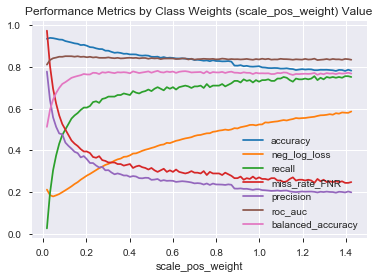

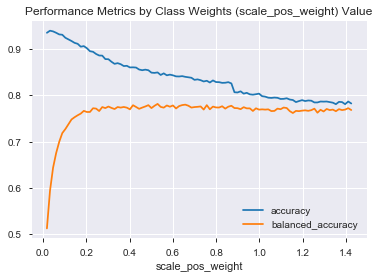

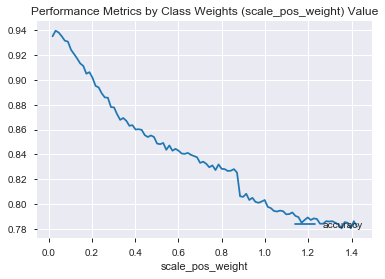

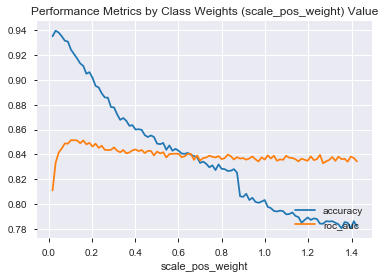

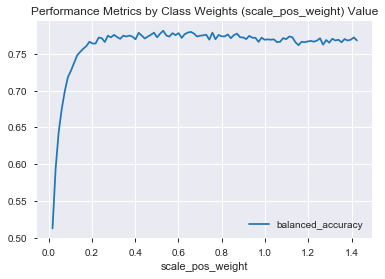

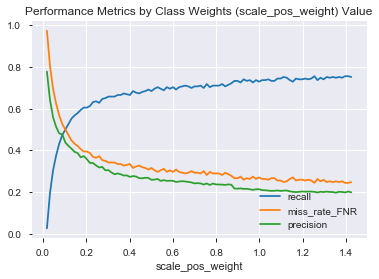

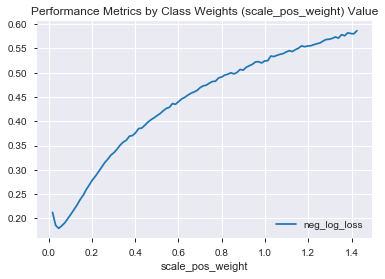

In [573]:
# Plot the key performance metrics from above by scale_pos_weights value:

# Plot all metrics:
metrics_to_plot = reweighting_scores_train_imbalanced.columns
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Accuracy vs. Balanced Accuracy:
metrics_to_plot = ['accuracy', 'balanced_accuracy']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Accuracy Only:
metrics_to_plot = ['accuracy']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Accuracy vs. Balanced Accuracy vs. ROC_AUC:
metrics_to_plot = ['accuracy', 'roc_auc']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Balanced Accuracy:
metrics_to_plot = ['balanced_accuracy']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Recall (and its inverse, FPR) vs. Precision:
metrics_to_plot = ['recall', 'miss_rate_FNR', 'precision']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Log loss:
metrics_to_plot = ['neg_log_loss']
plot_metrics_by_weights(reweighting_scores_train_imbalanced, metrics_to_plot)

# Alternative Model: Limit Loss in Accuracy, While Keeping Majority of TPs (Recall) Gained:

In [574]:
# Select optimal scale_pos_weights value (based on the above performance metrics):
optimal_scale_pos_weight = 0.3

In [575]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')  # Impute NaNs for permuter (next cell), even though not needed for XGBClassifier
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

m_accuracy = clone(m3_gbt_tuned_early)
m_accuracy = m_accuracy.set_params(scale_pos_weight=optimal_scale_pos_weight, n_estimators=m3_gbt_tuned_early.best_ntree_limit)

m_accuracy.fit(X_train_transformed, y_train)

# --------- TRAIN --------------------------------------------
print('\nFinal Model: Gradient-boosted Trees w/ Optimized Hyperparameters:\n')

# Performance on training data:
y_true_m_accuracy_train = y_train
y_pred_m_accuracy_train = m_accuracy.predict(X_train_transformed)
y_pred_m_accuracy_train_proba = m_accuracy.predict_proba(X_train_transformed)[:, -1]

# Get TP, FN, FP, TN:
cm_m_accuracy_train = pd.DataFrame(confusion_matrix(y_true_m_accuracy_train, y_pred_m_accuracy_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m_accuracy_train.loc['actual_1', 'pred_1']
FN = cm_m_accuracy_train.loc['actual_1', 'pred_0']
FP = cm_m_accuracy_train.loc['actual_0', 'pred_1']
TN = cm_m_accuracy_train.loc['actual_0', 'pred_0']

print('TRAINING SET:')
print(f'Accuracy: {accuracy_score(y_true_m_accuracy_train, y_pred_m_accuracy_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f'Log loss (negative): {log_loss(y_true_m_accuracy_train, y_pred_m_accuracy_train_proba, eps=10**-15):.3f}')
print(f"Recall : {recall_score(y_true_m_accuracy_train, y_pred_m_accuracy_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
print(f"Precision: {precision_score(y_true_m_accuracy_train, y_pred_m_accuracy_train, average='binary'):.3f}")  # TP / (TP + FP)
print(f"ROC AUC: {roc_auc_score(y_true_m_accuracy_train, y_pred_m_accuracy_train_proba):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_m_accuracy_train, y_pred_m_accuracy_train):.3f}\n")

# print('Confusion matrix, normalized:')
# assert round((cm_m_accuracy_train / cm_m_accuracy_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m_accuracy_train / cm_m_accuracy_train.sum().sum()

# --------- TRAIN_IMBALANCED --------------------------------------------
y_true_m_accuracy_train_imbalanced = y_train_imbalanced
y_pred_m_accuracy_train_imbalanced = m_accuracy.predict(X_train_imbalanced_transformed)
y_pred_m_accuracy_train_imbalanced_proba = m_accuracy.predict_proba(X_train_imbalanced_transformed)[:, -1]

# Get TP, FN, FP, TN:
cm_m_accuracy_train_imbalanced = pd.DataFrame(confusion_matrix(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m_accuracy_train_imbalanced.loc['actual_1', 'pred_1']
FN = cm_m_accuracy_train_imbalanced.loc['actual_1', 'pred_0']
FP = cm_m_accuracy_train_imbalanced.loc['actual_0', 'pred_1']
TN = cm_m_accuracy_train_imbalanced.loc['actual_0', 'pred_0']

print('TRAIN_IMBALANCED:')
print(f'Accuracy: {accuracy_score(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f'Log loss (negative): {log_loss(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced_proba, eps=10**-15):.3f}')
print(f"Recall : {recall_score(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
print(f"Precision: {precision_score(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced, average='binary'):.3f}")  # TP / (TP + FP)
print(f"ROC AUC: {roc_auc_score(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced_proba):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_m_accuracy_train_imbalanced, y_pred_m_accuracy_train_imbalanced):.3f}")

# print('Confusion matrix, normalized:')
# assert round((cm_m_accuracy_train_imbalanced / cm_m_accuracy_train_imbalanced.sum().sum()).sum().sum(), 10) == 1.0
# cm_m_accuracy_train_imbalanced / cm_m_accuracy_train_imbalanced.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m_accuracy_val = y_val
y_pred_m_accuracy_val = m_accuracy.predict(X_val_transformed)
y_pred_m_accuracy_val_proba = m_accuracy.predict_proba(X_val_transformed)[:, -1]

# Get TP, FN, FP, TN:
cm_m_accuracy_val = pd.DataFrame(confusion_matrix(y_true_m_accuracy_val, y_pred_m_accuracy_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m_accuracy_val.loc['actual_1', 'pred_1']
FN = cm_m_accuracy_val.loc['actual_1', 'pred_0']
FP = cm_m_accuracy_val.loc['actual_0', 'pred_1']
TN = cm_m_accuracy_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:')
print(f'Accuracy: {accuracy_score(y_true_m_accuracy_val, y_pred_m_accuracy_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f'Log loss (negative): {log_loss(y_true_m_accuracy_val, y_pred_m_accuracy_val_proba, eps=10**-15):.3f}')
print(f"Recall: {recall_score(y_true_m_accuracy_val, y_pred_m_accuracy_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
print(f"Precision: {precision_score(y_true_m_accuracy_val, y_pred_m_accuracy_val, average='binary'):.3f}")  # TP / (TP + FP)
print(f"ROC AUC: {roc_auc_score(y_true_m_accuracy_val, y_pred_m_accuracy_val_proba):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_m_accuracy_val, y_pred_m_accuracy_val):.3f}\n")

print('Confusion matrix, normalized:')
assert round((cm_m_accuracy_val / cm_m_accuracy_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m_accuracy_val / cm_m_accuracy_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Final Model: Gradient-boosted Trees w/ Optimized Hyperparameters:

TRAINING SET:
Accuracy: 0.776
Log loss (negative): 0.498
Recall : 0.586
"Miss Rate" (FNR): 0.414
Precision: 0.947
ROC AUC: 0.898
Balanced Accuracy: 0.776

TRAIN_IMBALANCED:
Accuracy: 0.916
Log loss (negative): 0.257
Recall : 0.590
"Miss Rate" (FNR): 0.410
Precision: 0.409
ROC AUC: 0.855
Balanced Accuracy: 0.765

VALIDATION SET:
Accuracy: 0.912
Log loss (negative): 0.264
Recall: 0.604
"Miss Rate" (FNR): 0.396
Precision: 0.373
ROC AUC: 0.851
Balanced Accuracy: 0.768

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.87400  0.06350
actual_1  0.02475  0.03775

In [576]:
# Show accuracy-first model:
m_accuracy

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05870049639060088, max_delta_step=0, max_depth=30,
              min_child_weight=9.069129770507795, missing=None,
              n_estimators=106, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.3, seed=None, silent=None,
              subsample=1, verbosity=1)

# Final Model:

In [577]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')  # Impute NaNs for permuter (next cell), even though not needed for XGBClassifier
)

X_train_transformed = transformers.fit_transform(X_train)
X_train_imbalanced_transformed = transformers.transform(X_train_imbalanced)
X_val_transformed = transformers.transform(X_val)

mfinal = clone(m3_gbt_tuned_early)
mfinal = mfinal.set_params(n_estimators=m3_gbt_tuned_early.best_ntree_limit)

mfinal.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_mfinal_train = y_train
y_pred_mfinal_train = mfinal.predict(X_train_transformed)
y_pred_mfinal_train_proba = mfinal.predict_proba(X_train_transformed)[:, -1]

# Get TP, FN, FP, TN:
cm_mfinal_train = pd.DataFrame(confusion_matrix(y_true_mfinal_train, y_pred_mfinal_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_train.loc['actual_1', 'pred_1']
FN = cm_mfinal_train.loc['actual_1', 'pred_0']
FP = cm_mfinal_train.loc['actual_0', 'pred_1']
TN = cm_mfinal_train.loc['actual_0', 'pred_0']

print('\nFinal Model: Gradient-boosted Trees w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:')
print(f'Accuracy: {accuracy_score(y_true_mfinal_train, y_pred_mfinal_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f'Log loss (negative): {log_loss(y_true_mfinal_train, y_pred_mfinal_train_proba, eps=10**-15):.3f}')
print(f"Recall : {recall_score(y_true_mfinal_train, y_pred_mfinal_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
print(f"Precision: {precision_score(y_true_mfinal_train, y_pred_mfinal_train, average='binary'):.3f}")  # TP / (TP + FP)
print(f"ROC AUC: {roc_auc_score(y_true_mfinal_train, y_pred_mfinal_train_proba):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_mfinal_train, y_pred_mfinal_train):.3f}\n")

# print('Confusion matrix, normalized:')
# assert round((cm_mfinal_train / cm_mfinal_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_mfinal_train / cm_mfinal_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_mfinal_val = y_val
y_pred_mfinal_val = mfinal.predict(X_val_transformed)
y_pred_mfinal_val_proba = mfinal.predict_proba(X_val_transformed)[:, -1]

# Get TP, FN, FP, TN:
cm_mfinal_val = pd.DataFrame(confusion_matrix(y_true_mfinal_val, y_pred_mfinal_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_val.loc['actual_1', 'pred_1']
FN = cm_mfinal_val.loc['actual_1', 'pred_0']
FP = cm_mfinal_val.loc['actual_0', 'pred_1']
TN = cm_mfinal_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:')
print(f'Accuracy: {accuracy_score(y_true_mfinal_val, y_pred_mfinal_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f'Log loss (negative): {log_loss(y_true_mfinal_val, y_pred_mfinal_val_proba, eps=10**-15):.3f}')
print(f"Recall: {recall_score(y_true_mfinal_val, y_pred_mfinal_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
print(f"Precision: {precision_score(y_true_mfinal_val, y_pred_mfinal_val, average='binary'):.3f}")  # TP / (TP + FP)
print(f"ROC AUC: {roc_auc_score(y_true_mfinal_val, y_pred_mfinal_val_proba):.3f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true_mfinal_val, y_pred_mfinal_val):.3f}\n")

print('Confusion matrix, normalized:')
assert round((cm_mfinal_val / cm_mfinal_val.sum().sum()).sum().sum(), 10) == 1.0
cm_mfinal_val / cm_mfinal_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Final Model: Gradient-boosted Trees w/ Optimized Hyperparameters:

TRAINING SET:
Accuracy: 0.884
Log loss (negative): 0.311
Recall : 0.896
"Miss Rate" (FNR): 0.104
Precision: 0.875
ROC AUC: 0.961
Balanced Accuracy: 0.884


VALIDATION SET:
Accuracy: 0.787
Log loss (negative): 0.557
Recall: 0.812
"Miss Rate" (FNR): 0.188
Precision: 0.201
ROC AUC: 0.856
Balanced Accuracy: 0.799

Confusion matrix, normalized:


pred_0   pred_1
actual_0  0.73600  0.20150
actual_1  0.01175  0.05075

In [578]:
# Show final model:
mfinal

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05870049639060088, max_delta_step=0, max_depth=30,
              min_child_weight=9.069129770507795, missing=None,
              n_estimators=106, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1.424745581146224, seed=None,
              silent=None, subsample=1, verbosity=1)

# Model Explanation:

### Permutation Importances:

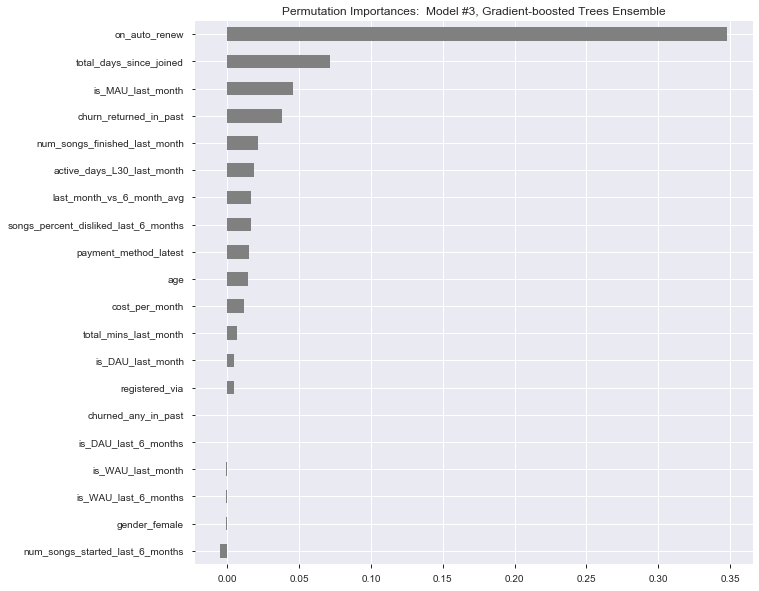

In [579]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_mfinal = PermutationImportance(
    mfinal, 
    scoring='recall',  # [?? To do: Change scoring in all permuters to -- what, negative log loss ??]
    n_iter=10, 
    random_state=42
)

permuter_mfinal.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_mfinal = pd.Series(permuter_mfinal.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_mfinal.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [580]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_mfinal, 
    top=None, 
    feature_names=feature_names
)

### Shap Plot: Breaking Down How Our Model Makes 1 Single Prediction:

In [665]:
# Get a random observation from our final model:
random_row_num = np.random.randint(0, len(X_val))
single_observation = X_val.iloc[[random_row_num]]
single_observation

total_days_since_joined is_WAU_last_6_months  is_DAU_last_month  \
2886                   2911.0                False              False   

     is_DAU_last_6_months  registered_via churn_returned_in_past  \
2886                False             9.0                  False   

      is_MAU_last_month   age  total_mins_last_month  \
2886               True  36.0              2310.6255   

      num_songs_started_last_6_months churned_any_in_past  \
2886                           5155.0               False   

      last_month_vs_6_month_avg  is_WAU_last_month  cost_per_month  \
2886                   0.910427               True           149.0   

      active_days_L30_last_month  num_songs_finished_last_month  \
2886                        12.0                          551.0   

      on_auto_renew  gender_female  payment_method_latest  \
2886            1.0              0                   33.0   

      songs_percent_disliked_last_6_months  
2886                              0.246557

In [666]:
# Actual value (did/didn't churn in Feb. 2017) for that randomly selected observation:
y_val.iloc[random_row_num]

0

In [678]:
# Our final model's prediction (will/won't churn in March 2017) for this 1 observation:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
single_observation_transformed = transformers.fit_transform(single_observation)

round(mfinal.predict_proba(single_observation_transformed)[0][1], 2)

0.24

In [679]:
# Shap plot explaining this prediction:
import shap

explainer = shap.TreeExplainer(mfinal)
shap_values = explainer.shap_values(single_observation_transformed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=single_observation, 
    link='logit'
)